# Content Based Filtering using MovieLens Dataset

## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import seaborn as sns
import re
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Data Preparation

In [2]:
movies = pd.read_csv('../ml-latest-small/movies.csv')
ratings = pd.read_csv('../ml-latest-small/ratings.csv')
links = pd.read_csv('../ml-latest-small/links.csv')
tags = pd.read_csv('../ml-latest-small/tags.csv')

## Data Exploration

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [5]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


It can be seen from the below table that the min and max rating from the user is 0.5 and 5.0 respectively. The average rating value is 3.5
Total user is 610 and total movies is 193609

In [6]:
merged_dataset = pd.merge(movies, ratings, how='inner', on='movieId')
merged_dataset.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [7]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### List of all genres

In [9]:
genres = []
for genre in movies.genres:
    x = genre.split('|')
    #print(x)
    for i in x:
        if(i not in genres):
            genres.append(str(i))
print(genres)

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)']


### Popular Genres

(-0.5, 999.5, 399.5, -0.5)

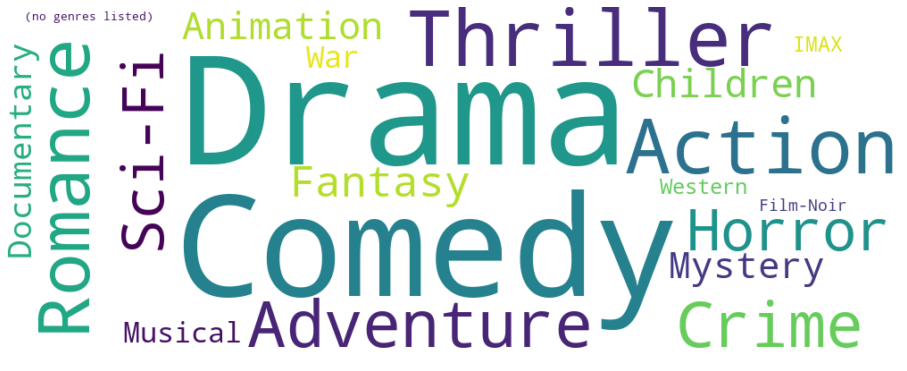

In [10]:
genre_popularity = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

### Popular Movies

(-0.5, 999.5, 399.5, -0.5)

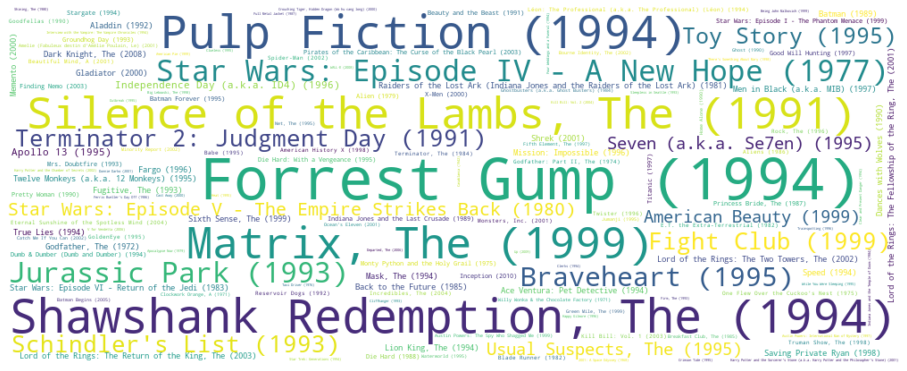

In [11]:
sorted_by_rating = merged_dataset.sort_values(by = ['rating'])
movie_popularity = (sorted_by_rating.title
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(movie_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

### movie count by genre

<ipython-input-12-c0cab21f091a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


Text(0, 0.5, 'Counts')

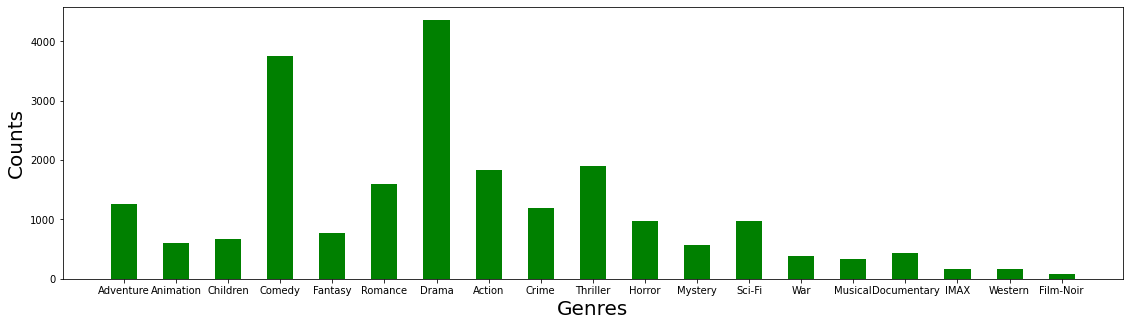

In [12]:
# remove '|' in the genres column
movies['genres'] = movies['genres'].str.replace('|',' ')
# count the number of occurences for each genre in the data set
counts = dict()
for i in movies.index:
    for g in movies.loc[i,'genres'].split(' '):
        if g not in counts:
            counts[g] = 1
        else:
            counts[g] = counts[g] + 1
counts.pop("(no")
counts.pop("genres")
counts.pop("listed)")
# create a bar chart
plt.figure(figsize=(19,5))
plt.bar(list(counts.keys()), counts.values(), color='g', align='center', width=0.5)
plt.xticks()
plt.xlabel('Genres', fontsize=20)
plt.ylabel('Counts', fontsize=20)

### Movie count by year

Text(0, 0.5, 'Movie Count')

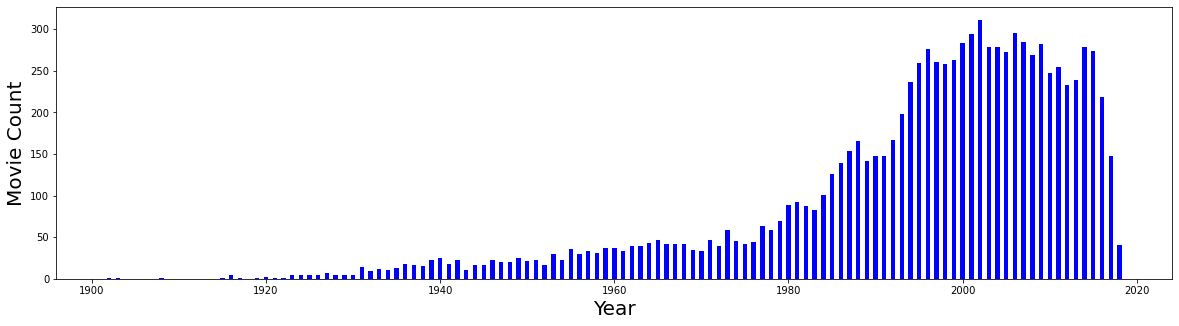

In [13]:
#\b\d+\b
year = list()
for i in movies.index:
    for s in re.findall(r'^.*?\([^\d]*(\d{4})[^\d]*\).*$', movies.loc[i,'title']) :
        year.append(int(s))
year.sort()
counts = dict()
for i in year:
    if i not in counts:
            counts[i] = 1
    else:
            counts[i] = counts[i] + 1

plt.figure(figsize=(20,5))
plt.bar(list(counts.keys()), counts.values(), color='b', align='center', width=0.5)
plt.xticks()
plt.xlabel('Year', fontsize=20)
plt.ylabel('Movie Count', fontsize=20)

## Ratings

/Users/spoorthichinivar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

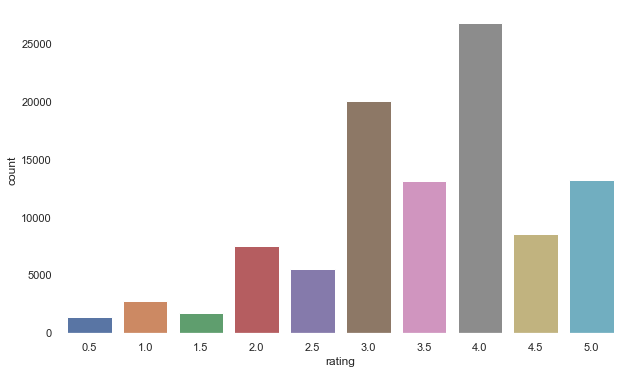

In [14]:
plt.figure(figsize=(10,6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.countplot(ratings['rating'].fillna(ratings['rating'].median()))

## Data Modelling

In [15]:
def create_model(col,analyzer):
    content = movies[col].fillna('')
    if analyzer == None:
        tfidf = TfidfVectorizer(stop_words='english')
    else:
        tfidf = TfidfVectorizer(stop_words='english', analyzer = analyzer)
    tfidf_matrix = tfidf.fit_transform(content)
    cosine_similarities = cosine_similarity(tfidf_matrix)    
    
    return cosine_similarities

## Recommender

In [16]:
def get_recommendations(df, column, value, cosine_similarities, limit=10):
    """Return a dataframe of content recommendations based on TF-IDF cosine similarity.
    
    Args:
        df (object): Pandas dataframe containing the text data. 
        column (string): Name of column used, i.e. 'title'. 
        value (string): Name of title to get recommendations for, i.e. 1982 Ferrari 308 GTSi For Sale by Auction
        cosine_similarities (array): Cosine similarities matrix from linear_kernel
        limit (int, optional): Optional limit on number of recommendations to return. 
        
    Returns: 
        Pandas dataframe. 
    """
    
    # Return indices for the target dataframe column and drop any duplicates
    indices = pd.Series(df.index, index=df[column]).drop_duplicates()
    #print(indices)
    # Get the index for the target value
    
    #print(target_index)
    
    if column == 'genres':
        for i, row in indices.iteritems():
            if value == i:
                target_index = row
                break
    else:
        target_index = indices[value]
           
    #print(target_index)      
    
    # Get the cosine similarity scores for the target value
    cosine_similarity_scores = list(enumerate(cosine_similarities[target_index]))
    
    # Sort the cosine similarities in order of closest similarity
    try:
        cosine_similarity_scores.sort(key=lambda x:( x[1] ), reverse=True)
    except ValueError :
            cosine_similarity_scores.sort(key=lambda x:( x[1] ).any(), reverse=True)
    
    #cosine_similarity_scores = cosine_similarity_scores.sort_values(ascending = False)
   

    # Return tuple of the requested closest scores excluding the target item and index
    cosine_similarity_scores = cosine_similarity_scores[1:limit+1]

    # Extract the tuple values
    scores = (x[1] for x in cosine_similarity_scores)    

    # Get the indices for the closest items
    recommendation_indices = [i[0] for i in cosine_similarity_scores]

    # Get the actutal recommendations
    recommendations = df[column].iloc[recommendation_indices]
     # Return a dataframe
    if column == 'genres':
        return (pd.DataFrame(recommendations).merge(df).head(limit))
    else :
        df = pd.DataFrame(list(zip(recommendations, scores)), 
                      columns=['recommendation', 'cosine_similarity_score']) 

        return df.head(limit)
    

 

## Test the recommender

### Top 10 rated movies by a random user with genre

In [17]:
#select random user
d = pd.DataFrame(columns = ['movieId', 'Rating'])
f = pd.DataFrame(columns = ['Title', 'Genres'])
user = ratings.userId.sample().tolist()
print("User : ", user)


#select top 10 highly rated movies by this user

d = pd.DataFrame({"movieId" : row.movieId, "Rating" : row.rating} for i,row in ratings.iterrows() if  row.userId == user)
d = d.sort_values(by=['Rating'], ascending=False)
top_rated_movies = d.head(10)
#print(top_rated_movies)
#select genres of top 10 rated movies
f = pd.DataFrame({"Title" : row.title, "Genres" : row.genres} for i,row in movies.iterrows() for mov in top_rated_movies["movieId"] if row.movieId == mov)
f.style
#print(f.to_string(index = False))



User :  [522]


,Title,Genres
0,Alien (1979),Horror Sci-Fi
1,Back to the Future (1985),Adventure Comedy Sci-Fi
2,Saving Private Ryan (1998),Action Drama War
3,Inception (2010),Action Crime Drama Mystery Sci-Fi Thriller IMAX
4,Scott Pilgrim vs. the World (2010),Action Comedy Fantasy Musical Romance
5,"King's Speech, The (2010)",Drama
6,Tron: Legacy (2010),Action Adventure Sci-Fi IMAX
7,Louis C.K.: Hilarious (2010),Comedy
8,Louis C.K.: Shameless (2007),Comedy
9,Louis C.K.: Live at The Comedy Store (2015),Comedy


In [18]:
cosine_similarities = create_model("title",None)

### Test Recommender based on Title

In [19]:
title_recommended_movies = list()
for title in f['Title']:
    recommendations = get_recommendations(movies, 
                                      'title', 
                                      title, 
                                      cosine_similarities)
   
    for i in recommendations['recommendation']:
        title_recommended_movies.append(i)
    #print(recommended_movies)
    print("Because you have watched : {} ".format(title))
    display(recommendations[:10])

Because you have watched : Alien (1979) 


,recommendation,cosine_similarity_score
0,Alien from L.A. (1988),0.661350
1,Being There (1979),0.610563
2,Alien Nation (1988),0.496719
3,Alien: Resurrection (1997),0.496126
4,Alien: Covenant (2017),0.469418
5,Alien³ (a.k.a. Alien 3) (1992),0.460981
6,My Stepmother Is an Alien (1988),0.460821
7,Alien Contamination (1980),0.452392
8,1941 (1979),0.388756
9,10 (1979),0.377510


Because you have watched : Back to the Future (1985) 


,recommendation,cosine_similarity_score
0,Back to the Future Part II (1989),0.601764
1,Back to the Future Part III (1990),0.580932
2,D.A.R.Y.L. (1985),0.555245
3,Guest from the Future (Gostya iz buduschego) (...,0.455236
4,"X-Files: Fight the Future, The (1998)",0.437551
5,X-Men: Days of Future Past (2014),0.434914
6,"History of Future Folk, The (2012)",0.428831
7,"Last Dragon, The (1985)",0.353893
8,Legend (1985),0.346147
9,Perfect (1985),0.332246


Because you have watched : Saving Private Ryan (1998) 


,recommendation,cosine_similarity_score
0,Saving Christmas (2014),0.389100
1,Saving Santa (2013),0.359779
2,Saving Face (2004),0.358062
3,Saving Grace (2000),0.354244
4,Private School (1983),0.342055
5,"Private Eyes, The (1981)",0.339082
6,Private Parts (1997),0.325348
7,Von Ryan's Express (1965),0.321804
8,My Own Private Idaho (1991),0.319864
9,Private Benjamin (1980),0.310182


Because you have watched : Inception (2010) 


,recommendation,cosine_similarity_score
0,Please Give (2010),0.441249
1,I'm Still Here (2010),0.441249
2,You Again (2010),0.441249
3,Hereafter (2010),0.441249
4,Somewhere (2010),0.441249
5,Everything Must Go (2010),0.441249
6,I'm Here (2010),0.441249
7,The Man from Nowhere (2010),0.302589
8,"American, The (2010)",0.266487
9,"Next Three Days, The (2010)",0.261158


Because you have watched : Scott Pilgrim vs. the World (2010) 


,recommendation,cosine_similarity_score
0,In This World (2002),0.288936
1,Were the World Mine (2008),0.285673
2,"World Is Not Enough, The (1999)",0.285166
3,In a World... (2013),0.283021
4,Please Give (2010),0.274043
5,I'm Still Here (2010),0.274043
6,You Again (2010),0.274043
7,Hereafter (2010),0.274043
8,Somewhere (2010),0.274043
9,Everything Must Go (2010),0.274043


Because you have watched : King's Speech, The (2010) 


,recommendation,cosine_similarity_score
0,We Could Be King (2014),0.411379
1,"King and I, The (1999)",0.409649
2,Please Give (2010),0.379840
3,I'm Still Here (2010),0.379840
4,You Again (2010),0.379840
5,Hereafter (2010),0.379840
6,Somewhere (2010),0.379840
7,Everything Must Go (2010),0.379840
8,I'm Here (2010),0.379840
9,"King and I, The (1956)",0.345813


Because you have watched : Tron: Legacy (2010) 


,recommendation,cosine_similarity_score
0,Tron (1982),0.570721
1,"Bourne Legacy, The (2012)",0.443575
2,Please Give (2010),0.346183
3,I'm Still Here (2010),0.346183
4,You Again (2010),0.346183
5,Hereafter (2010),0.346183
6,Somewhere (2010),0.346183
7,Everything Must Go (2010),0.346183
8,I'm Here (2010),0.346183
9,The Man from Nowhere (2010),0.237397


Because you have watched : Louis C.K.: Hilarious (2010) 


,recommendation,cosine_similarity_score
0,Louis C.K.: Shameless (2007),0.358369
1,Louis C.K.: Chewed Up (2008),0.357826
2,Please Give (2010),0.353810
3,I'm Still Here (2010),0.353810
4,You Again (2010),0.353810
5,Hereafter (2010),0.353810
6,Somewhere (2010),0.353810
7,Everything Must Go (2010),0.353810
8,I'm Here (2010),0.353810
9,Louis C.K.: Oh My God (2013),0.335256


Because you have watched : Louis C.K.: Shameless (2007) 


,recommendation,cosine_similarity_score
0,Louis C.K.: Chewed Up (2008),0.359143
1,Louis C.K.: Hilarious (2010),0.358369
2,Next (2007),0.344571
3,Are We Done Yet? (2007),0.344571
4,"Ten, The (2007)",0.344571
5,I'm Not There (2007),0.344571
6,Louis C.K.: Oh My God (2013),0.336490
7,The Death of Louis XIV (2016),0.322910
8,Meet Me in St. Louis (1944),0.308215
9,Louis C.K.: Live at The Comedy Store (2015),0.284177


Because you have watched : Louis C.K.: Live at The Comedy Store (2015) 


,recommendation,cosine_similarity_score
0,Louis C.K.: Live at the Beacon Theater (2011),0.372613
1,They Live (1988),0.324432
2,"King of Comedy, The (1983)",0.305810
3,Louis C.K.: Shameless (2007),0.284177
4,Louis C.K.: Chewed Up (2008),0.283747
5,Louis C.K.: Hilarious (2010),0.283135
6,B/W (2015),0.274592
7,Me Him Her (2015),0.274592
8,You Only Live Once (1937),0.274481
9,Louis C.K.: Oh My God (2013),0.265849


### Test Recommender based on Genre

In [20]:
cosine_similarities = create_model("genres",lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
genre_recommended_movies = list()
for genre in f['Genres']:
    x = genre.split('|')
    #print(x)
    for i in x:
        recommendations = get_recommendations(movies, 
                                      'genres', 
                                      str(i), 
                                      cosine_similarities)
        for j in recommendations['title']:
            genre_recommended_movies.append(j)
        print("More {} movies :".format( str(i)))
        display(recommendations[["movieId",'title']][:10])

More Horror Sci-Fi movies :


,movieId,title
0,196,Species (1995)
1,332,Village of the Damned (1995)
2,512,"Puppet Masters, The (1994)"
3,1214,Alien (1979)
4,1334,"Blob, The (1958)"
5,1862,Species II (1998)
6,1924,Plan 9 from Outer Space (1959)
7,2256,Parasite (1982)
8,2377,Lifeforce (1985)
9,2428,"Faculty, The (1998)"


More Adventure Comedy Sci-Fi movies :


,movieId,title
0,674,Barbarella (1968)
1,1270,Back to the Future (1985)
2,1376,Star Trek IV: The Voyage Home (1986)
3,2011,Back to the Future Part II (1989)
4,2450,Howard the Duck (1986)
5,3070,Adventures of Buckaroo Banzai Across the 8th D...
6,3175,Galaxy Quest (1999)
7,4571,Bill & Ted's Excellent Adventure (1989)
8,5497,Our Man Flint (1965)
9,5596,Spaced Invaders (1990)


More Action Drama War movies :


,movieId,title
0,110,Braveheart (1995)
1,1208,Apocalypse Now (1979)
2,1233,"Boot, Das (Boat, The) (1981)"
3,1927,All Quiet on the Western Front (1930)
4,2028,Saving Private Ryan (1998)
5,2427,"Thin Red Line, The (1998)"
6,2944,"Dirty Dozen, The (1967)"
7,3062,"Longest Day, The (1962)"
8,3066,Tora! Tora! Tora! (1970)
9,3441,Red Dawn (1984)


More Action Crime Drama Mystery Sci-Fi Thriller IMAX movies :


,movieId,title
0,1,Toy Story (1995)
1,2294,Antz (1998)
2,3114,Toy Story 2 (1999)
3,3754,"Adventures of Rocky and Bullwinkle, The (2000)"
4,4016,"Emperor's New Groove, The (2000)"
5,4886,"Monsters, Inc. (2001)"
6,45074,"Wild, The (2006)"
7,53121,Shrek the Third (2007)
8,65577,"Tale of Despereaux, The (2008)"
9,91355,Asterix and the Vikings (Astérix et les Viking...


More Action Comedy Fantasy Musical Romance movies :


,movieId,title
0,1,Toy Story (1995)
1,2294,Antz (1998)
2,3114,Toy Story 2 (1999)
3,3754,"Adventures of Rocky and Bullwinkle, The (2000)"
4,4016,"Emperor's New Groove, The (2000)"
5,4886,"Monsters, Inc. (2001)"
6,45074,"Wild, The (2006)"
7,53121,Shrek the Third (2007)
8,65577,"Tale of Despereaux, The (2008)"
9,91355,Asterix and the Vikings (Astérix et les Viking...


More Drama movies :


,movieId,title
0,14,Nixon (1995)
1,26,Othello (1995)
2,31,Dangerous Minds (1995)
3,40,"Cry, the Beloved Country (1995)"
4,43,Restoration (1995)
5,55,Georgia (1995)
6,57,Home for the Holidays (1995)
7,62,Mr. Holland's Opus (1995)
8,121,"Boys of St. Vincent, The (1992)"
9,147,"Basketball Diaries, The (1995)"


More Action Adventure Sci-Fi IMAX movies :


,movieId,title
0,5378,Star Wars: Episode II - Attack of the Clones (...
1,8636,Spider-Man 2 (2004)
2,46530,Superman Returns (2006)
3,68358,Star Trek (2009)
4,69526,Transformers: Revenge of the Fallen (2009)
5,72998,Avatar (2009)
6,82461,Tron: Legacy (2010)
7,89745,"Avengers, The (2012)"
8,93363,John Carter (2012)
9,95510,"Amazing Spider-Man, The (2012)"


More Comedy movies :


,movieId,title
0,5,Father of the Bride Part II (1995)
1,18,Four Rooms (1995)
2,19,Ace Ventura: When Nature Calls (1995)
3,65,Bio-Dome (1996)
4,69,Friday (1995)
5,88,Black Sheep (1996)
6,102,Mr. Wrong (1996)
7,104,Happy Gilmore (1996)
8,119,"Steal Big, Steal Little (1995)"
9,125,Flirting With Disaster (1996)


More Comedy movies :


,movieId,title
0,5,Father of the Bride Part II (1995)
1,18,Four Rooms (1995)
2,19,Ace Ventura: When Nature Calls (1995)
3,65,Bio-Dome (1996)
4,69,Friday (1995)
5,88,Black Sheep (1996)
6,102,Mr. Wrong (1996)
7,104,Happy Gilmore (1996)
8,119,"Steal Big, Steal Little (1995)"
9,125,Flirting With Disaster (1996)


More Comedy movies :


,movieId,title
0,5,Father of the Bride Part II (1995)
1,18,Four Rooms (1995)
2,19,Ace Ventura: When Nature Calls (1995)
3,65,Bio-Dome (1996)
4,69,Friday (1995)
5,88,Black Sheep (1996)
6,102,Mr. Wrong (1996)
7,104,Happy Gilmore (1996)
8,119,"Steal Big, Steal Little (1995)"
9,125,Flirting With Disaster (1996)


## Evaluate the recommender

### Defining test dataset

In [21]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0


In [22]:
#Encode target labels with value between 0 and n_classes-1.
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['userId'].values)
n_users = refined_dataset['user'].nunique()

In [23]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['title'].values)
n_movies = refined_dataset['movie'].nunique()

In [24]:
refined_dataset.head()

,userId,title,rating,user,movie
0,1,"13th Warrior, The (1999)",4.0,0,48
1,1,20 Dates (1998),4.0,0,66
2,1,"Abyss, The (1989)",4.0,0,202
3,1,"Adventures of Robin Hood, The (1938)",5.0,0,245
4,1,Alice in Wonderland (1951),5.0,0,325


In [25]:
# Let's say we want to split the data in 75:10:15 for train:valid:test dataset
train_size=0.75

X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.75)
#print(y_train)
# Now since we want the valid and test size to be 10% and 15% respectively 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.6
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.6)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(75624, 2)
(75624,)
(10083, 2)
(10083,)
(15125, 2)
(15125,)


(None, None)

In [26]:
test_set = pd.DataFrame(X_test)
test_set

,0,1
0,453,6117
1,214,7975
2,327,5129
3,375,8001
4,110,3839
...,...,...
15120,437,2747
15121,516,3742
15122,121,1673
15123,461,563


### Call recommender System

In [27]:
#list of movies with cosine similarity score recommended to all users

def recommender(cosine_similarities, seen_movies):
    rec = pd.DataFrame(columns=['recommendation', 'cosine_similarity_score'])
    title_recommended_movies =list()
    for title in seen_movies['title']:
        #print(title)
        recommendations = get_recommendations(movies, 
                                      'title', 
                                      title, 
                                      cosine_similarities)
        #print(recommendations)
        #recommendations = recommendations.sort_values(by = ['cosine_similarity_score'] , ascending = False)
        #print(recommendations)
    
        for i in recommendations['recommendation']:
            title_recommended_movies.append(i)
    print(" Top 10 recommended movies are :{}".format(title_recommended_movies[:10]))    
    #print(title_recommended_movies))
    return title_recommended_movies

#### precision = no of movies watched by user also recommended / total no of recommendations

#### recall = no of movies watched by user also recommended / total no of movies watched by user

In [29]:
overall_precision = list()
overall_recall = list()
overall_FScore = list()

for i, user_movie in test_set.groupby(0):
    model_input = user_movie
    user = list(set(model_input[0]))
  
    seen_movies = refined_dataset[refined_dataset['user'] == user[0]]
    #list(refined_dataset[movies['userId'] == user_id]['title'])
    print("User {} has watched total {} movies".format(user,len(seen_movies)))
    print("Top 10 watched movies are ,")
    print(seen_movies['title'][:10])
    
    input = list(row.title for i,row in refined_dataset.iterrows() for i in model_input[1]  if row.movie == i and row.user == user[0])   
    cosine_similarities = create_model("title",None)
    recommended_movies = recommender(cosine_similarities,pd.DataFrame(input, columns = ['title']))
    
    recommended_movies_list = list(set(recommended_movies))
    
    print("Total Unique Recommended movies for user {} is {} ".format(user,len(recommended_movies_list) ))
    
    
    
    #Calculate precision Recall and F1 score using top 50 recommended movies
    
    
    
    movies_recommeded_for_user_bytitle = pd.DataFrame({'title':recommended_movies_list})
     
    count = pd.merge(movies_recommeded_for_user_bytitle, seen_movies, how='inner', on='title').shape[0]
    print(count)
    if count == 0:
        precision =0
        recall =0
        F_Score =0
    else:
        precision = count/len(recommended_movies_list)
        recall = count / len(seen_movies)
        F_Score = 2 * ( (precision * recall) / (precision + recall) )
    
    overall_precision.append(precision)
    overall_recall.append(recall)
    overall_FScore.append(F_Score)
    
    print("Precision: {}  Recall: {}  F-Score: {}".format(precision,recall,F_Score))
    print("**************************************")
    print("\n\n")
    
    

User [0] has watched total 232 movies
Top 10 watched movies are ,
0                 13th Warrior, The (1999)
1                          20 Dates (1998)
2                        Abyss, The (1989)
3     Adventures of Robin Hood, The (1938)
4               Alice in Wonderland (1951)
5                             Alien (1979)
6    All Quiet on the Western Front (1930)
7                   American Beauty (1999)
8                American History X (1998)
9                 American Tail, An (1986)
Name: title, dtype: object
 Top 10 recommended movies are :['Quiet American, The (2002)', 'Divorcee, The (1930)', 'The Quiet Family (1998)', 'Quiet Earth, The (1985)', 'Quiet Man, The (1952)', 'A Quiet Place (2018)', 'Anna Christie (1930)', 'Animal Crackers (1930)', 'Decline of Western Civilization, The (1981)', 'Sukiyaki Western Django (2008)']
Total Unique Recommended movies for user [0] is 293 
18
Precision: 0.06143344709897611  Recall: 0.07758620689655173  F-Score: 0.06857142857142856
**********

 Top 10 recommended movies are :['Raiders of the Lost Ark: The Adaptation (1989)', 'Enough (2002)', 'Below (2002)', 'All or Nothing (2002)', 'They (2002)', 'May (2002)', 'In This World (2002)', 'About a Boy (2002)', 'In America (2002)', '8 Women (2002)']
Total Unique Recommended movies for user [8] is 40 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [9] has watched total 140 movies
Top 10 watched movies are ,
1119                 27 Dresses (2008)
1120                        300 (2007)
1121             50 First Dates (2004)
1122                 About Time (2013)
1123                About a Boy (2002)
1124                    Aladdin (1992)
1125    Amazing Spider-Man, The (2012)
1126            American Beauty (1999)
1127         As Good as It Gets (1997)
1128                     Avatar (2009)
Name: title, dtype: object
 Top 10 recommended movies are :['The Second Best Exotic Marigold Hotel (2015)', 'Best of the Best (1989)', 'Best in Show (2000)',

 Top 10 recommended movies are :['Why We Fight (2005)', 'Fist Fight (2017)', 'Club Paradise (1986)', "The Emperor's Club (2002)", "She's All That (1999)", 'Go (1999)', 'Anywhere But Here (1999)', 'First Wives Club, The (1996)', 'X-Files: Fight the Future, The (1998)', 'Breakfast Club, The (1985)']
Total Unique Recommended movies for user [16] is 120 
7
Precision: 0.058333333333333334  Recall: 0.06666666666666667  F-Score: 0.06222222222222222
**************************************



User [17] has watched total 502 movies
Top 10 watched movies are ,
1772                    (500) Days of Summer (2009)
1773    00 Schneider - Jagd auf Nihil Baxter (1994)
1774                            12 Angry Men (1957)
1775                    20,000 Days on Earth (2014)
1776                   2001: A Space Odyssey (1968)
1777                                    2012 (2009)
1778                                     300 (2007)
1779                          50 First Dates (2004)
1780                         

 Top 10 recommended movies are :['Deadpool (2016)', 'Game Over, Man! (2018)', 'Alpha (2018)', 'When We First Met (2018)', 'Spiral (2018)', 'Game Night (2018)', 'Annihilation (2018)', 'Incredibles 2 (2018)', 'The Commuter (2018)', 'The Clapper (2018)']
Total Unique Recommended movies for user [24] is 70 
2
Precision: 0.02857142857142857  Recall: 0.07692307692307693  F-Score: 0.041666666666666664
**************************************



User [25] has watched total 21 movies
Top 10 watched movies are ,
4038    Ace Ventura: Pet Detective (1994)
4039                     Apollo 13 (1995)
4040                          Babe (1995)
4041                        Batman (1989)
4042                Batman Forever (1995)
4043      Clear and Present Danger (1994)
4044                   Cliffhanger (1993)
4045    Die Hard: With a Vengeance (1995)
4046                    Disclosure (1994)
4047                     Firm, The (1993)
Name: title, dtype: object
 Top 10 recommended movies are :['Ace Ventura: 

 Top 10 recommended movies are :['The Queen (2006)', 'Desert Hearts (1985)', 'Queen of the Damned (2002)', 'Sons of the Desert (1933)', 'Queen of Versailles, The (2012)', 'I.Q. (1994)', 'Only You (1994)', 'S.F.W. (1994)', 'African Queen, The (1951)', 'Adventures of Pinocchio, The (1996)']
Total Unique Recommended movies for user [32] is 188 
5
Precision: 0.026595744680851064  Recall: 0.03205128205128205  F-Score: 0.029069767441860468
**************************************



User [33] has watched total 86 movies
Top 10 watched movies are ,
5186    Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
5187                       Appleseed (Appurushîdo) (2004)
5188                                      Bad Boys (1995)
5189                                    Braveheart (1995)
5190                         Bridget Jones's Diary (2001)
5191                              Buffalo Soldiers (2001)
5192                              Charlie's Angels (2000)
5193        Chinese Ghost Story, A (Sinnui yauwa

 Top 10 recommended movies are :['Latter Days (2003)', 'Last Days (2005)', 'Last Days, The (1998)', 'Next Three Days, The (2010)', 'Up (2009)', '9 (2009)', 'Summer School (1987)', 'One Crazy Summer (1986)', 'Summer Catch (2001)', 'Kings of Summer, The (2013)']
Total Unique Recommended movies for user [40] is 225 
15
Precision: 0.06666666666666667  Recall: 0.06912442396313365  F-Score: 0.06787330316742081
**************************************



User [41] has watched total 440 movies
Top 10 watched movies are ,
5874                          20 Dates (1998)
5875             2001: A Space Odyssey (1968)
5876    2010: The Year We Make Contact (1984)
5877                           28 Days (2000)
5878                         8 Seconds (1994)
5879                               8MM (1999)
5880                     Above the Law (1988)
5881                        Abyss, The (1989)
5882        Ace Ventura: Pet Detective (1994)
5883    Ace Ventura: When Nature Calls (1995)
Name: title, dtype: obj

 Top 10 recommended movies are :['Saving Christmas (2014)', 'Saving Santa (2013)', 'Saving Face (2004)', 'Saving Grace (2000)', 'Private School (1983)', 'Private Eyes, The (1981)', 'Private Parts (1997)', "Von Ryan's Express (1965)", 'My Own Private Idaho (1991)', 'Private Benjamin (1980)']
Total Unique Recommended movies for user [48] is 20 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [49] has watched total 310 movies
Top 10 watched movies are ,
7111                101 Dalmatians (1996)
7112                     127 Hours (2010)
7113         2001: A Space Odyssey (1968)
7114                          2012 (2009)
7115                    8 1/2 (8½) (1963)
7116                        8 Mile (2002)
7117                 A German Life (2016)
7118     Adventures of Tintin, The (2011)
7119            African Queen, The (1951)
7120    Afro Samurai: Resurrection (2009)
Name: title, dtype: object
 Top 10 recommended movies are :['Afro Samurai (2007)', 'Last

 Top 10 recommended movies are :['Ace Ventura: When Nature Calls (1995)', 'A Detective Story (2003)', 'Pet Sematary (1989)', "Teacher's Pet (1958)", 'Cheap Detective, The (1978)', 'Pet Sematary II (1992)', 'Great Mouse Detective, The (1986)', 'I.Q. (1994)', 'Only You (1994)', 'S.F.W. (1994)']
Total Unique Recommended movies for user [57] is 126 
4
Precision: 0.031746031746031744  Recall: 0.03571428571428571  F-Score: 0.03361344537815126
**************************************



User [58] has watched total 107 movies
Top 10 watched movies are ,
8622             2001: A Space Odyssey (1968)
8623                     39 Steps, The (1935)
8624                African Queen, The (1951)
8625    All Quiet on the Western Front (1930)
8626                        Angel Baby (1995)
8627                              Antz (1998)
8628                    Apocalypse Now (1979)
8629              Arsenic and Old Lace (1944)
8630                   Assignment, The (1997)
8631                       Beetlejui

 Top 10 recommended movies are :['Raiders of the Lost Ark: The Adaptation (1989)', 'Enough (2002)', 'Below (2002)', 'All or Nothing (2002)', 'They (2002)', 'May (2002)', 'In This World (2002)', 'About a Boy (2002)', 'In America (2002)', '8 Women (2002)']
Total Unique Recommended movies for user [65] is 419 
35
Precision: 0.08353221957040573  Recall: 0.10144927536231885  F-Score: 0.09162303664921466
**************************************



User [66] has watched total 36 movies
Top 10 watched movies are ,
10323                American Beauty (1999)
10324             American History X (1998)
10325             Back to the Future (1985)
10326     Back to the Future Part II (1989)
10327    Back to the Future Part III (1990)
10328           Bourne Identity, The (2002)
10329                       Die Hard (1988)
10330               Django Unchained (2012)
10331             Fifth Element, The (1997)
10332                     Fight Club (1999)
Name: title, dtype: object
 Top 10 recommended mov

 Top 10 recommended movies are :["We Don't Live Here Anymore (2004)", 'Alice (2009)', 'Still Alice (2014)', 'Alice (1990)', 'They Live (1988)', 'Alice in Wonderland (2010)', 'You Only Live Once (1937)', 'Alice in Wonderland (1951)', 'Alice in Wonderland (1933)', 'Alice Adams (1935)']
Total Unique Recommended movies for user [73] is 261 
6
Precision: 0.022988505747126436  Recall: 0.03389830508474576  F-Score: 0.0273972602739726
**************************************



User [74] has watched total 69 movies
Top 10 watched movies are ,
12193      2001: A Space Odyssey (1968)
12194                      Alien (1979)
12195                     Aliens (1986)
12196    Alien³ (a.k.a. Alien 3) (1992)
12197      Andromeda Strain, The (1971)
12198                     Batman (1989)
12199               Blade Runner (1982)
12200                     Brazil (1985)
12201                 Casablanca (1942)
12202                  Coneheads (1993)
Name: title, dtype: object
 Top 10 recommended movies are :['

 Top 10 recommended movies are :['Con Air (1997)', 'G-Force (2009)', 'Up in the Air (2009)', 'Air Up There, The (1994)', 'Air Bud (1997)', 'Air America (1990)', 'Air I Breathe, The (2007)', 'Delta Force, The (1986)', 'B*A*P*S (1997)', 'Nowhere (1997)']
Total Unique Recommended movies for user [81] is 272 
24
Precision: 0.08823529411764706  Recall: 0.10572687224669604  F-Score: 0.09619238476953909
**************************************



User [82] has watched total 118 movies
Top 10 watched movies are ,
12955                         2001: A Space Odyssey (1968)
12956                                 28 Days Later (2002)
12957                                           300 (2007)
12958                  A.I. Artificial Intelligence (2001)
12959                                     Alexander (2004)
12960                                       Amadeus (1984)
12961    Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
12962                               American Beauty (1999)
12963              

 Top 10 recommended movies are :['The Diary of Anne Frank (2009)', 'The Diary of Anne Frank (1959)', 'Frank (2014)', 'Anne of Green Gables: The Sequel (a.k.a. Anne of Avonlea) (1987)', 'Robot & Frank (2012)', 'Now and Then (1995)', 'Two Much (1995)', 'Anne of the Thousand Days (1969)', 'Anne of Green Gables (1985)', 'Wild Bill (1995)']
Total Unique Recommended movies for user [89] is 129 
2
Precision: 0.015503875968992248  Recall: 0.037037037037037035  F-Score: 0.021857923497267756
**************************************



User [90] has watched total 575 movies
Top 10 watched movies are ,
14119                                   'burbs, The (1989)
14120                   1984 (Nineteen Eighty-Four) (1984)
14121                         2001: A Space Odyssey (1968)
14122                     7th Voyage of Sinbad, The (1958)
14123                                    Abyss, The (1989)
14124                    Ace Ventura: Pet Detective (1994)
14125                Ace Ventura: When Nature Call

 Top 10 recommended movies are :['Alice in Wonderland (1951)', 'Alice in Wonderland (1933)', 'Wonderland (2003)', 'Wonderland (1999)', 'Alice (2009)', 'Still Alice (2014)', 'Alice (1990)', 'Next Stop Wonderland (1998)', 'Please Give (2010)', "I'm Still Here (2010)"]
Total Unique Recommended movies for user [97] is 145 
4
Precision: 0.027586206896551724  Recall: 0.043478260869565216  F-Score: 0.03375527426160337
**************************************



User [98] has watched total 53 movies
Top 10 watched movies are ,
15245    Ace Ventura: Pet Detective (1994)
15246                      Airheads (1994)
15247                       Aladdin (1992)
15248                     Apollo 13 (1995)
15249                     Assassins (1995)
15250                      Bad Boys (1995)
15251                     Bad Girls (1994)
15252                        Batman (1989)
15253                Batman Forever (1995)
15254         Beverly Hills Cop III (1994)
Name: title, dtype: object
 Top 10 recommended 

 Top 10 recommended movies are :['Chronicles of Narnia: Prince Caspian, The (2008)', 'Chronicles of Narnia: The Voyage of the Dawn Treader, The (2010)', 'Lion (2016)', 'The Witch (2015)', 'Lion King, The (1994)', 'Midnight Chronicles (2009)', 'Mutant Chronicles (2008)', 'Lion in Winter, The (1968)', 'Wind and the Lion, The (1975)', 'The Last Witch Hunter (2015)']
Total Unique Recommended movies for user [105] is 50 
4
Precision: 0.08  Recall: 0.12121212121212122  F-Score: 0.09638554216867469
**************************************



User [106] has watched total 34 movies
Top 10 watched movies are ,
16968                    Ace Ventura: Pet Detective (1994)
16969                          Addams Family Values (1993)
16970                       American President, The (1995)
16971                                     Apollo 13 (1995)
16972                                Batman Forever (1995)
16973                                 Birdcage, The (1996)
16974                                   

 Top 10 recommended movies are :["Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", 'Harry Potter and the Goblet of Fire (2005)', 'Harry Potter and the Chamber of Secrets (2002)', 'Harry Potter and the Order of the Phoenix (2007)', 'Harry Potter and the Deathly Hallows: Part 2 (2011)', 'Harry Potter and the Deathly Hallows: Part 1 (2010)', 'Harry Potter and the Half-Blood Prince (2009)', 'Spanish Prisoner, The (1997)', 'Miss Potter (2006)', 'Very Potter Musical, A (2009)']
Total Unique Recommended movies for user [113] is 50 
10
Precision: 0.2  Recall: 0.3225806451612903  F-Score: 0.24691358024691357
**************************************



User [114] has watched total 112 movies
Top 10 watched movies are ,
18147    Airplane II: The Sequel (1982)
18148                    Aladdin (1992)
18149                     Aliens (1986)
18150            American Beauty (1999)
18151             Apocalypse Now (1979)
18152                       Babe (1

 Top 10 recommended movies are :['28 Days (2000)', '28 Weeks Later (2007)', '28 Up (1985)', 'Latter Days (2003)', 'Last Days (2005)', 'Last Days, The (1998)', 'Next Three Days, The (2010)', 'Garage Days (2002)', 'Enough (2002)', 'Below (2002)']
Total Unique Recommended movies for user [121] is 425 
21
Precision: 0.04941176470588235  Recall: 0.07191780821917808  F-Score: 0.058577405857740586
**************************************



User [122] has watched total 56 movies
Top 10 watched movies are ,
19120                              21 (2008)
19121                 American Beauty (1999)
19122               American Gangster (2007)
19123              American History X (1998)
19124                 Angels & Demons (2009)
19125                   Avengers, The (2012)
19126                      Big Hero 6 (2014)
19127           Bourne Ultimatum, The (2007)
19128    City of God (Cidade de Deus) (2002)
19129                Django Unchained (2012)
Name: title, dtype: object
 Top 10 recommended 

 Top 10 recommended movies are :['Avengers, The (1998)', 'Ultimate Avengers (2006)', 'Ultimate Avengers 2 (2006)', 'Masked Avengers (1981)', 'V/H/S (2012)', 'Side by Side (2012)', 'Fire with Fire (2012)', 'Avengers: Infinity War - Part I (2018)', 'Avengers: Age of Ultron (2015)', '2012 (2009)']
Total Unique Recommended movies for user [130] is 69 
3
Precision: 0.043478260869565216  Recall: 0.043478260869565216  F-Score: 0.043478260869565216
**************************************



User [131] has watched total 347 movies
Top 10 watched movies are ,
19916                    10 Things I Hate About You (1999)
19917                                13 Going on 30 (2004)
19918                          24 Hour Party People (2002)
19919                                   About a Boy (2002)
19920                    Ace Ventura: Pet Detective (1994)
19921                          Addams Family Values (1993)
19922                            Addams Family, The (1991)
19923    Adventures of Priscilla

 Top 10 recommended movies are :['28 Days Later (2002)', '9 1/2 Weeks (Nine 1/2 Weeks) (1986)', '28 Up (1985)', '28 Days (2000)', 'Two Weeks Notice (2002)', 'Next (2007)', 'Are We Done Yet? (2007)', 'Ten, The (2007)', "I'm Not There (2007)", '4 Months, 3 Weeks and 2 Days (4 luni, 3 saptamâni si 2 zile) (2007)']
Total Unique Recommended movies for user [138] is 309 
18
Precision: 0.05825242718446602  Recall: 0.09278350515463918  F-Score: 0.07157057654075548
**************************************



User [139] has watched total 608 movies
Top 10 watched movies are ,
21080    101 Dalmatians (One Hundred and One Dalmatians...
21081                                    15 Minutes (2001)
21082                  20,000 Leagues Under the Sea (1954)
21083                         2001: A Space Odyssey (1968)
21084                                 About Schmidt (2002)
21085                                   About a Boy (2002)
21086                                Absolute Power (1997)
21087           

 Top 10 recommended movies are :['Knight and Day (2010)', 'Black Knight (2001)', 'Dark Knight, The (2008)', "Knight's Tale, A (2001)", 'Now and Then (1995)', 'Two Much (1995)', 'Tales from the Crypt Presents: Demon Knight (1995)', 'Dark Knight Rises, The (2012)', 'Batman: Gotham Knight (2008)', 'Batman: The Dark Knight Returns, Part 2 (2013)']
Total Unique Recommended movies for user [146] is 48 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [147] has watched total 48 movies
Top 10 watched movies are ,
22168                   (500) Days of Summer (2009)
22169                                 Avatar (2009)
22170                          Avengers, The (2012)
22171                             Big Hero 6 (2014)
22172             Captain America: Civil War (2016)
22173    Captain America: The Winter Soldier (2014)
22174                          Despicable Me (2010)
22175                           Finding Dory (2016)
22176                           Findi

 Top 10 recommended movies are :["Everybody's Famous! (Iedereen beroemd!) (2000)", 'Down to You (2000)', 'Me Myself I (2000)', 'Dracula 2000 (2000)', 'Pokémon the Movie 2000 (2000)', 'Heavy Metal 2000 (2000)', 'X-Men (2000)', 'Return to Me (2000)', 'Woman on Top (2000)', 'Here on Earth (2000)']
Total Unique Recommended movies for user [155] is 512 
37
Precision: 0.072265625  Recall: 0.09296482412060302  F-Score: 0.08131868131868132
**************************************



User [156] has watched total 21 movies
Top 10 watched movies are ,
23079    Austin Powers: The Spy Who Shagged Me (1999)
23080                       Back to the Future (1985)
23081                              Boiler Room (2000)
23082                                Bowfinger (1999)
23083                               Fight Club (1999)
23084                             Galaxy Quest (1999)
23085                         Inspector Gadget (1999)
23086                    It's a Wonderful Life (1946)
23087                  

 Top 10 recommended movies are :['Raiders of the Lost Ark: The Adaptation (1989)', 'Enough (2002)', 'Below (2002)', 'All or Nothing (2002)', 'They (2002)', 'May (2002)', 'In This World (2002)', 'About a Boy (2002)', 'In America (2002)', '8 Women (2002)']
Total Unique Recommended movies for user [164] is 110 
2
Precision: 0.01818181818181818  Recall: 0.03076923076923077  F-Score: 0.022857142857142857
**************************************



User [165] has watched total 190 movies
Top 10 watched movies are ,
23861                                 28 Days Later (2002)
23862                                           300 (2007)
23863                                  3:10 to Yuma (2007)
23864                       40-Year-Old Virgin, The (2005)
23865                                       Aladdin (1992)
23866                                         Alien (1979)
23867                                 Almost Famous (2000)
23868                                       Amadeus (1984)
23869    Amelie

 Top 10 recommended movies are :['To Do List, The (2013)', 'Kill List (2011)', 'Voices from the List (2004)', 'Bucket List, The (2007)', 'My Life (1993)', 'Made in America (1993)', 'In the Name of the Father (1993)', 'Cop and ½ (1993)', 'Fire in the Sky (1993)', 'Being Human (1993)']
Total Unique Recommended movies for user [172] is 10 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [173] has watched total 67 movies
Top 10 watched movies are ,
24770    Ace Ventura: Pet Detective (1994)
24771          Addams Family Values (1993)
24772                       Aladdin (1992)
24773       American President, The (1995)
24774                     Apollo 13 (1995)
24775                          Babe (1995)
24776                        Batman (1989)
24777                Batman Forever (1995)
24778          Beauty and the Beast (1991)
24779         Beverly Hills Cop III (1994)
Name: title, dtype: object
 Top 10 recommended movies are :['Babe, The (1992)', 'Bab

 Top 10 recommended movies are :['Death of a President (2006)', "All the President's Men (1976)", 'Hunting of the President, The (2004)', 'American, The (2010)', 'American Me (1992)', 'American Made (2017)', 'Now and Then (1995)', 'Two Much (1995)', 'American Wedding (American Pie 3) (2003)', 'Assassination of a High School President (2008)']
Total Unique Recommended movies for user [180] is 108 
7
Precision: 0.06481481481481481  Recall: 0.059322033898305086  F-Score: 0.061946902654867256
**************************************



User [181] has watched total 977 movies
Top 10 watched movies are ,
26089                    10 Things I Hate About You (1999)
26090                             13th Warrior, The (1999)
26091                                    15 Minutes (2001)
26092                   1984 (Nineteen Eighty-Four) (1984)
26093                          2 Days in the Valley (1996)
26094    2 Fast 2 Furious (Fast and the Furious 2, The)...
26095                         2001: A Spac

 Top 10 recommended movies are :['Dark Knight Rises, The (2012)', 'First Knight (1995)', 'Batman: The Dark Knight Returns, Part 2 (2013)', 'Batman: The Dark Knight Returns, Part 1 (2012)', 'Alone in the Dark II (2008)', 'Knight and Day (2010)', 'Black Knight (2001)', 'Batman: Gotham Knight (2008)', "Knight's Tale, A (2001)", 'Alone in the Dark (2005)']
Total Unique Recommended movies for user [188] is 30 
1
Precision: 0.03333333333333333  Recall: 0.05  F-Score: 0.04
**************************************



User [189] has watched total 66 movies
Top 10 watched movies are ,
27856                                        8 Mile (2002)
27857                                   About a Boy (2002)
27858                                    Adaptation (2002)
27859    Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
27860       And Your Mother Too (Y tu mamá también) (2001)
27861                   Austin Powers in Goldmember (2002)
27862                             Beautiful Mind, A (2001)
27863  

 Top 10 recommended movies are :['The Odyssey (1997)', 'Yours, Mine and Ours (1968)', 'The Space Between Us (2016)', 'Billabong Odyssey (2003)', 'Story of Film: An Odyssey, The (2011)', 'Lost in Space (1998)', 'Get Over It (2001)', 'Made (2001)', 'Others, The (2001)', 'O (2001)']
Total Unique Recommended movies for user [197] is 212 
4
Precision: 0.018867924528301886  Recall: 0.017391304347826087  F-Score: 0.01809954751131222
**************************************



User [198] has watched total 363 movies
Top 10 watched movies are ,
28568                                      21 Grams (2003)
28569                  A.I. Artificial Intelligence (2001)
28570                                   About a Boy (2002)
28571                                    Adaptation (2002)
28572    Adventures of Priscilla, Queen of the Desert, ...
28573                            African Queen, The (1951)
28574    Aguirre: The Wrath of God (Aguirre, der Zorn G...
28575                                 Air Force

 Top 10 recommended movies are :['Broken Arrow (1950)', 'Broken (2012)', 'Broken English (1996)', 'Broken Flowers (2005)', 'Broken Hearts Club, The (2000)', 'Before and After (1996)', "She's the One (1996)", 'Broken Wings (Knafayim Shvurot) (2002)', 'Girl 6 (1996)', 'Boys (1996)']
Total Unique Recommended movies for user [205] is 40 
1
Precision: 0.025  Recall: 0.04  F-Score: 0.030769230769230767
**************************************



User [206] has watched total 20 movies
Top 10 watched movies are ,
29958                    American Beauty (1999)
29959                 American History X (1998)
29960    American Werewolf in London, An (1981)
29961                     Arlington Road (1999)
29962              Babe: Pig in the City (1998)
29963        Big Trouble in Little China (1986)
29964           Buffy the Vampire Slayer (1992)
29965                          City Hall (1996)
29966                             Dr. No (1962)
29967                               Dune (1984)
Name: title

 Top 10 recommended movies are :['Amy (2015)', "Amy's O (a.k.a. Amy's Orgasm) (2001)", 'Chasing Liberty (2004)', 'B*A*P*S (1997)', 'Nowhere (1997)', 'In & Out (1997)', 'Fire Down Below (1997)', 'Chasing Papi (a.k.a. Papi Chulo) (2003)', 'Big One, The (1997)', 'Game, The (1997)']
Total Unique Recommended movies for user [214] is 170 
1
Precision: 0.0058823529411764705  Recall: 0.01020408163265306  F-Score: 0.00746268656716418
**************************************



User [215] has watched total 164 movies
Top 10 watched movies are ,
30718           6th Day, The (2000)
30719              Airplane! (1980)
30720                Aladdin (1992)
30721    Alice in Wonderland (1951)
30722          Almost Famous (2000)
30723        American Beauty (1999)
30724      American Graffiti (1973)
30725      American Tail, An (1986)
30726           Animal House (1978)
30727             Annie Hall (1977)
Name: title, dtype: object
 Top 10 recommended movies are :['American Tail: Fievel Goes West, An (199

 Top 10 recommended movies are :['300: Rise of an Empire (2014)', 'Next (2007)', 'Are We Done Yet? (2007)', 'Ten, The (2007)', "I'm Not There (2007)", 'P.S. I Love You (2007)', 'What Love Is (2007)', 'We Own the Night (2007)', 'Boy A (2007)', 'There Will Be Blood (2007)']
Total Unique Recommended movies for user [222] is 99 
3
Precision: 0.030303030303030304  Recall: 0.04  F-Score: 0.03448275862068965
**************************************



User [223] has watched total 54 movies
Top 10 watched movies are ,
32912     African Queen, The (1951)
32913              Airplane! (1980)
32914     Back to the Future (1985)
32915            Beetlejuice (1988)
32916                    Big (1988)
32917                  Blade (1998)
32918    Breakfast Club, The (1985)
32919            Bull Durham (1988)
32920             Caddyshack (1980)
32921     Christmas Story, A (1983)
Name: title, dtype: object
 Top 10 recommended movies are :['D.O.A. (1988)', 'The Night Before (1988)', 'Big (1988)', 'Eight M

 Top 10 recommended movies are :['The Godfather Trilogy: 1972-1990 (1992)', 'Godfather: Part III, The (1990)', 'Godfather: Part II, The (1974)', 'Candidate, The (1972)', 'Getaway, The (1972)', "What's Up, Doc? (1972)", 'Fuzz (1972)', 'Sleuth (1972)', 'Frenzy (1972)', 'Deliverance (1972)']
Total Unique Recommended movies for user [230] is 20 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [231] has watched total 862 movies
Top 10 watched movies are ,
33895                          (500) Days of Summer (2009)
33896                              10 Items or Less (2006)
33897                                     10,000 BC (2008)
33898                                         11:14 (2003)
33899                                13 Going on 30 (2004)
33900                                          1408 (2007)
33901                                      17 Again (2009)
33902    2 Fast 2 Furious (Fast and the Furious 2, The)...
33903                               

 Top 10 recommended movies are :['All of Me (1984)', 'Top Secret! (1984)', '1984 (Nineteen Eighty-Four) (1984)', 'River, The (1984)', 'Runaway (1984)', 'Terminator, The (1984)', 'Bounty, The (1984)', 'Dune (1984)', 'Natural, The (1984)', "Breakin' (1984)"]
Total Unique Recommended movies for user [238] is 348 
24
Precision: 0.06896551724137931  Recall: 0.08602150537634409  F-Score: 0.07655502392344499
**************************************



User [239] has watched total 128 movies
Top 10 watched movies are ,
35577                    101 Dalmatians (1996)
35578        Ace Ventura: Pet Detective (1994)
35579    Ace Ventura: When Nature Calls (1995)
35580              Addams Family Values (1993)
35581                          Airheads (1994)
35582                           Aladdin (1992)
35583                         Apollo 13 (1995)
35584                              Babe (1995)
35585                            Batman (1989)
35586                    Batman Forever (1995)
Name: title, dt

 Top 10 recommended movies are :['300: Rise of an Empire (2014)', 'Next (2007)', 'Are We Done Yet? (2007)', 'Ten, The (2007)', "I'm Not There (2007)", 'P.S. I Love You (2007)', 'What Love Is (2007)', 'We Own the Night (2007)', 'Boy A (2007)', 'There Will Be Blood (2007)']
Total Unique Recommended movies for user [246] is 176 
14
Precision: 0.07954545454545454  Recall: 0.09333333333333334  F-Score: 0.08588957055214724
**************************************



User [247] has watched total 51 movies
Top 10 watched movies are ,
36320                                Arrival (2016)
36321        Avengers: Infinity War - Part I (2018)
36322                          Batman Begins (2005)
36323                             Big Hero 6 (2014)
36324                      Blade Runner 2049 (2017)
36325                                   Coco (2017)
36326                       Dark Knight, The (2008)
36327                               Deadpool (2016)
36328                             Deadpool 2 (2018)
36

 Top 10 recommended movies are :['Blues Brothers 2000 (1998)', 'Brothers (2009)', 'Four Brothers (2005)', 'Nine to Five (a.k.a. 9 to 5) (1980)', 'Miami Blues (1990)', 'Undercover Blues (1993)', 'Varsity Blues (1999)', 'Genghis Blues (1999)', 'Even Cowgirls Get the Blues (1993)', 'Biloxi Blues (1988)']
Total Unique Recommended movies for user [254] is 50 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [255] has watched total 174 movies
Top 10 watched movies are ,
37723                                     10,000 BC (2008)
37724                                    15 Minutes (2001)
37725                                 28 Days Later (2002)
37726                                50 First Dates (2004)
37727            A Man from Boulevard des Capucines (1987)
37728                       Alien³ (a.k.a. Alien 3) (1992)
37729    Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
37730                                American Pie 2 (2001)
37731             Ameri

 Top 10 recommended movies are :['101 Dalmatians (1996)', "101 Dalmatians II: Patch's London Adventure (2003)", '102 Dalmatians (2000)', 'One, Two, Three (1961)', '101 Reykjavik (101 Reykjavík) (2000)', 'The Girls (1961)', 'Hustler, The (1961)', 'Misfits, The (1961)', 'Innocents, The (1961)', 'Yojimbo (1961)']
Total Unique Recommended movies for user [262] is 251 
16
Precision: 0.06374501992031872  Recall: 0.0761904761904762  F-Score: 0.06941431670281996
**************************************



User [263] has watched total 56 movies
Top 10 watched movies are ,
38443    101 Dalmatians (One Hundred and One Dalmatians...
38444                       Alien³ (a.k.a. Alien 3) (1992)
38445                                     Apollo 13 (1995)
38446                                    Armageddon (1998)
38447                             Beautiful Mind, A (2001)
38448                          Beauty and the Beast (1991)
38449                                    Braveheart (1995)
38450              

 Top 10 recommended movies are :['American Movie (1999)', 'American Pie (1999)', 'Black Beauty (1994)', 'American, The (2010)', 'American Me (1992)', 'American Made (2017)', "She's All That (1999)", 'Go (1999)', 'Anywhere But Here (1999)', 'Dangerous Beauty (1998)']
Total Unique Recommended movies for user [270] is 46 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [271] has watched total 31 movies
Top 10 watched movies are ,
39140      22 Jump Street (2014)
39141                 300 (2007)
39142       Avengers, The (2012)
39143      Big Short, The (2015)
39144               Blade (1998)
39145       Casino Royale (2006)
39146                Coco (2017)
39147           Divergent (2014)
39148    Django Unchained (2012)
39149      Doctor Strange (2016)
Name: title, dtype: object
 Top 10 recommended movies are :['Enough (2002)', 'Below (2002)', 'All or Nothing (2002)', 'They (2002)', 'May (2002)', 'In This World (2002)', 'About a Boy (2002)', 'In Ameri

 Top 10 recommended movies are :['The Odyssey (1997)', 'Yours, Mine and Ours (1968)', 'The Space Between Us (2016)', 'Billabong Odyssey (2003)', 'Story of Film: An Odyssey, The (2011)', 'Lost in Space (1998)', 'Get Over It (2001)', 'Made (2001)', 'Others, The (2001)', 'O (2001)']
Total Unique Recommended movies for user [278] is 154 
5
Precision: 0.032467532467532464  Recall: 0.028409090909090908  F-Score: 0.0303030303030303
**************************************



User [279] has watched total 196 movies
Top 10 watched movies are ,
41240              (500) Days of Summer (2009)
41241        10 Things I Hate About You (1999)
41242                          17 Again (2009)
41243                                21 (2008)
41244                    21 Jump Street (2012)
41245                        27 Dresses (2008)
41246                               300 (2007)
41247           40-Year-Old Virgin, The (2005)
41248        Ace Ventura: Pet Detective (1994)
41249    Ace Ventura: When Nature Call

 Top 10 recommended movies are :['Back to the Future (1985)', 'Back to the Future Part II (1989)', 'Exorcist III, The (1990)', 'Godfather: Part III, The (1990)', 'It (1990)', 'Men in Black III (M.III.B.) (M.I.B.³) (2012)', 'Slumber Party Massacre III (1990)', 'X-Files: Fight the Future, The (1998)', 'X-Men: Days of Future Past (2014)', 'History of Future Folk, The (2012)']
Total Unique Recommended movies for user [286] is 190 
5
Precision: 0.02631578947368421  Recall: 0.03289473684210526  F-Score: 0.029239766081871343
**************************************



User [287] has watched total 1055 movies
Top 10 watched movies are ,
42111                                   'burbs, The (1989)
42112                                101 Dalmatians (1996)
42113    101 Dalmatians (One Hundred and One Dalmatians...
42114                                          1408 (2007)
42115                   1984 (Nineteen Eighty-Four) (1984)
42116                  20,000 Leagues Under the Sea (1954)
42117      

 Top 10 recommended movies are :['Devil (2010)', 'She-Devil (1989)', "The Devil's Advocate (1997)", 'Love Is the Devil (1998)', 'House of the Devil, The (2009)', 'B*A*P*S (1997)', 'Nowhere (1997)', 'In & Out (1997)', 'Fire Down Below (1997)', 'Ride with the Devil (1999)']
Total Unique Recommended movies for user [294] is 90 
1
Precision: 0.011111111111111112  Recall: 0.024390243902439025  F-Score: 0.015267175572519083
**************************************



User [295] has watched total 27 movies
Top 10 watched movies are ,
44433                                    Braveheart (1995)
44434                                    Fight Club (1999)
44435    Fog of War: Eleven Lessons from the Life of Ro...
44436                                  Forrest Gump (1994)
44437                             Good Will Hunting (1997)
44438    Good, the Bad and the Ugly, The (Buono, il bru...
44439        In the Mood For Love (Fa yeung nin wa) (2000)
44440                                     Inception (201

 Top 10 recommended movies are :['New York, New York (1977)', 'New York, I Love You (2009)', '2 Days in New York (2012)', 'King of New York (1990)', 'King in New York, A (1957)', 'New York Stories (1989)', 'Autumn in New York (2000)', 'Gangs of New York (2002)', 'Sidewalks of New York (2001)', 'Synecdoche, New York (2008)']
Total Unique Recommended movies for user [302] is 60 
3
Precision: 0.05  Recall: 0.05660377358490566  F-Score: 0.05309734513274336
**************************************



User [303] has watched total 216 movies
Top 10 watched movies are ,
45725       20,000 Leagues Under the Sea (1954)
45726              2001: A Space Odyssey (1968)
45727                      Air Force One (1997)
45728                            Aladdin (1992)
45729    Aladdin and the King of Thieves (1996)
45730                              Alien (1979)
45731                Alien: Resurrection (1997)
45732                             Aliens (1986)
45733            Alien³ (a.k.a. Alien 3) (1992)
4

 Top 10 recommended movies are :['D.O.A. (1988)', 'The Night Before (1988)', 'Big (1988)', 'Eight Men Out (1988)', 'Cry in the Dark, A (1988)', '1969 (1988)', 'Another Woman (1988)', 'They Live (1988)', 'Cop (1988)', 'Alien from L.A. (1988)']
Total Unique Recommended movies for user [310] is 40 
1
Precision: 0.025  Recall: 0.03571428571428571  F-Score: 0.029411764705882353
**************************************



User [311] has watched total 223 movies
Top 10 watched movies are ,
48015                         2001: A Space Odyssey (1968)
48016                  A.I. Artificial Intelligence (2001)
48017                                 About Schmidt (2002)
48018                                    Abyss, The (1989)
48019                                    Adaptation (2002)
48020    Adventures of Buckaroo Banzai Across the 8th D...
48021                                         Alien (1979)
48022                                  Alien Nation (1988)
48023                           Alien: Res

 Top 10 recommended movies are :['Beauty and the Beast (2017)', 'Beauty and the Beast: The Enchanted Christmas (1997)', 'Beast of War, The (Beast, The) (1988)', 'Object of Beauty, The (1991)', 'Beast Within, The (1982)', 'The Boy and the Beast (2015)', 'American Beauty (1999)', 'Black Beauty (1994)', 'Beauty and the Beast (La belle et la bête) (1946)', 'Dangerous Beauty (1998)']
Total Unique Recommended movies for user [318] is 90 
1
Precision: 0.011111111111111112  Recall: 0.02857142857142857  F-Score: 0.016
**************************************



User [319] has watched total 20 movies
Top 10 watched movies are ,
49895                                       28 Days (2000)
49896                       Appleseed (Appurushîdo) (2004)
49897                                        Avatar (2009)
49898    Cowboy Bebop: The Movie (Cowboy Bebop: Tengoku...
49899                     District 13 (Banlieue 13) (2004)
49900                                     Gladiator (2000)
49901                 

 Top 10 recommended movies are :['Those Happy Days (2006)', 'Happy, Texas (1999)', 'Happy-Go-Lucky (2008)', 'Happy Feet (2006)', 'Happy Feet Two (2011)', 'Before and After (1996)', "She's the One (1996)", 'Happy Birthday to Me (1981)', 'Happy Accidents (2000)', 'Happy Endings (2005)']
Total Unique Recommended movies for user [326] is 30 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [327] has watched total 255 movies
Top 10 watched movies are ,
50667                       12 Angry Men (1957)
50668                   12 Years a Slave (2013)
50669              2001: A Space Odyssey (1968)
50670            40-Year-Old Virgin, The (2005)
50671                     50 First Dates (2004)
50672                          Airplane! (1980)
50673                            Aladdin (1992)
50674    Aladdin and the King of Thieves (1996)
50675                Alice in Wonderland (1951)
50676                             Aliens (1986)
Name: title, dtype: object
 Top 

 Top 10 recommended movies are :['Get Over It (2001)', 'Made (2001)', 'Others, The (2001)', 'O (2001)', 'L.I.E. (2001)', 'One, The (2001)', 'Me Without You (2001)', 'Closet, The (Placard, Le) (2001)', 'Divorce, Le (2003)', 'Horseman on the Roof, The (Hussard sur le toit, Le) (1995)']
Total Unique Recommended movies for user [335] is 102 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [336] has watched total 77 movies
Top 10 watched movies are ,
51890                                      Bad Boys (1995)
51891                                     Barb Wire (1996)
51892                                  Bed of Roses (1996)
51893                                      Bio-Dome (1996)
51894                                 Birdcage, The (1996)
51895    Bloodsport 2 (a.k.a. Bloodsport II: The Next K...
51896                                    Braveheart (1995)
51897                                  Broken Arrow (1996)
51898                                Cabl

 Top 10 recommended movies are :['Alien from L.A. (1988)', 'Being There (1979)', 'Alien Nation (1988)', 'Alien: Resurrection (1997)', 'Alien: Covenant (2017)', 'Alien³ (a.k.a. Alien 3) (1992)', 'My Stepmother Is an Alien (1988)', 'Alien Contamination (1980)', '1941 (1979)', '10 (1979)']
Total Unique Recommended movies for user [343] is 84 
2
Precision: 0.023809523809523808  Recall: 0.028985507246376812  F-Score: 0.026143790849673203
**************************************



User [344] has watched total 62 movies
Top 10 watched movies are ,
52651                    'Salem's Lot (2004)
52652              'Til There Was You (1997)
52653                              10 (1979)
52654                    12 Angry Men (1957)
52655                       13 Ghosts (1960)
52656    20,000 Leagues Under the Sea (1954)
52657           2001: A Space Odyssey (1968)
52658                      27 Dresses (2008)
52659                         28 Days (2000)
52660           3 Women (Three Women) (1977)
Name

 Top 10 recommended movies are :['Next (2007)', 'Are We Done Yet? (2007)', 'Ten, The (2007)', "I'm Not There (2007)", 'P.S. I Love You (2007)', 'What Love Is (2007)', 'We Own the Night (2007)', 'Boy A (2007)', 'There Will Be Blood (2007)', 'Into the Wild (2007)']
Total Unique Recommended movies for user [351] is 338 
24
Precision: 0.07100591715976332  Recall: 0.08163265306122448  F-Score: 0.07594936708860758
**************************************



User [352] has watched total 90 movies
Top 10 watched movies are ,
53489        Ace Ventura: Pet Detective (1994)
53490    Ace Ventura: When Nature Calls (1995)
53491                          Airheads (1994)
53492                           Aladdin (1992)
53493           American President, The (1995)
53494                              Babe (1995)
53495                          Bad Boys (1995)
53496                            Batman (1989)
53497                    Batman Forever (1995)
53498              Beauty and the Beast (1991)
Name: tit

 Top 10 recommended movies are :['American Pie (1999)', 'American Wedding (American Pie 3) (2003)', 'American Reunion (American Pie 4) (2012)', 'American Pie Presents: The Book of Love (American Pie 7: The Book of Love) (2009)', 'American Pie Presents: Band Camp (American Pie 4: Band Camp) (2005)', 'American Pie Presents Beta House (American Pie 6: Beta House) (2007)', 'American Pie Presents The Naked Mile (American Pie 5: The Naked Mile) (2006)', 'Pie in the Sky (1996)', 'American Astronaut, The (2001)', 'American, The (2010)']
Total Unique Recommended movies for user [360] is 94 
4
Precision: 0.0425531914893617  Recall: 0.041237113402061855  F-Score: 0.0418848167539267
**************************************



User [361] has watched total 109 movies
Top 10 watched movies are ,
54740    2001: A Space Odyssey (1968)
54741       American History X (1998)
54742           Apocalypse Now (1979)
54743            Avengers, The (2012)
54744                   Batman (1989)
54745            Bat

 Top 10 recommended movies are :['All of Me (1984)', 'Top Secret! (1984)', '1984 (Nineteen Eighty-Four) (1984)', 'River, The (1984)', 'Runaway (1984)', 'Terminator, The (1984)', 'Bounty, The (1984)', 'Dune (1984)', 'Natural, The (1984)', "Breakin' (1984)"]
Total Unique Recommended movies for user [368] is 133 
8
Precision: 0.06015037593984962  Recall: 0.06201550387596899  F-Score: 0.061068702290076333
**************************************



User [369] has watched total 93 movies
Top 10 watched movies are ,
55991                    10 Things I Hate About You (1999)
55992    Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
55993                               American Beauty (1999)
55994                            American History X (1998)
55995                                        Batman (1989)
55996                                 Batman Begins (2005)
55997                          Being John Malkovich (1999)
55998                             Big Lebowski, The (1998)
55999         

 Top 10 recommended movies are :['Thirteen Ghosts (a.k.a. Thir13en Ghosts) (2001)', 'District 13 (Banlieue 13) (2004)', 'Ghosts of Mars (2001)', 'Ghosts of the Abyss (2003)', 'Ghosts of Mississippi (1996)', 'Long Live Ghosts! (1977)', '13 Hours (2016)', 'Apollo 13 (1995)', 'Ward 13 (2003)', '13 Sins (2014)']
Total Unique Recommended movies for user [376] is 188 
12
Precision: 0.06382978723404255  Recall: 0.0916030534351145  F-Score: 0.07523510971786833
**************************************



User [377] has watched total 48 movies
Top 10 watched movies are ,
56791        American History X (1998)
56792                      Argo (2012)
56793             Batman Begins (2005)
56794     Bourne Ultimatum, The (2007)
56795                Collateral (2004)
56796    Dark Knight Rises, The (2012)
56797          Dark Knight, The (2008)
56798          Dead Man Walking (1995)
56799             Departed, The (2006)
56800          Django Unchained (2012)
Name: title, dtype: object
 Top 10 recommend

 Top 10 recommended movies are :['Down in the Valley (2005)', 'The Dark Valley (2014)', 'Valley Girl (1983)', 'Latter Days (2003)', 'Last Days (2005)', 'Last Days, The (1998)', 'Next Three Days, The (2010)', 'In the Valley of Elah (2007)', 'Beyond the Valley of the Dolls (1970)', 'Before and After (1996)']
Total Unique Recommended movies for user [384] is 219 
10
Precision: 0.045662100456621  Recall: 0.04975124378109453  F-Score: 0.04761904761904762
**************************************



User [385] has watched total 68 movies
Top 10 watched movies are ,
59163        Addams Family Values (1993)
59164                        Babe (1995)
59165                      Batman (1989)
59166              Batman Forever (1995)
59167      Brady Bunch Movie, The (1995)
59168                  Braveheart (1995)
59169                      Casino (1995)
59170    Clear and Present Danger (1994)
59171                      Clerks (1994)
59172                 Cliffhanger (1993)
Name: title, dtype: object


 Top 10 recommended movies are :['Up (2009)', '9 (2009)', '2012 (2009)', 'Serious Man, A (2009)', 'Mr. Nobody (2009)', 'Home (2009)', 'Year One (2009)', 'Road, The (2009)', 'Moon (2009)', 'Brothers (2009)']
Total Unique Recommended movies for user [392] is 97 
5
Precision: 0.05154639175257732  Recall: 0.04065040650406504  F-Score: 0.045454545454545456
**************************************



User [393] has watched total 23 movies
Top 10 watched movies are ,
60936    Ace Ventura: Pet Detective (1994)
60937          Addams Family Values (1993)
60938                       Aladdin (1992)
60939                     Apollo 13 (1995)
60940                          Babe (1995)
60941                        Batman (1989)
60942                Batman Forever (1995)
60943          Beauty and the Beast (1991)
60944                    Braveheart (1995)
60945            Dances with Wolves (1990)
Name: title, dtype: object
 Top 10 recommended movies are :['Addams Family, The (1991)', 'Addams Family Reu

 Top 10 recommended movies are :['Up (2009)', '9 (2009)', '2012 (2009)', 'Serious Man, A (2009)', 'Mr. Nobody (2009)', 'Home (2009)', 'Year One (2009)', 'Road, The (2009)', 'Moon (2009)', 'Brothers (2009)']
Total Unique Recommended movies for user [400] is 107 
7
Precision: 0.06542056074766354  Recall: 0.09722222222222222  F-Score: 0.0782122905027933
**************************************



User [401] has watched total 48 movies
Top 10 watched movies are ,
61268                                       Aladdin (1992)
61269                                      Bad Boys (1995)
61270    Bloodsport 2 (a.k.a. Bloodsport II: The Next K...
61271                              Bonnie and Clyde (1967)
61272                                  Broken Arrow (1996)
61273                      Clear and Present Danger (1994)
61274                                   Cliffhanger (1993)
61275                              Dead Man Walking (1995)
61276                                Demolition Man (1993)
61277  

 Top 10 recommended movies are :['More American Graffiti (1979)', 'Last Detail, The (1973)', 'American, The (2010)', 'American Me (1992)', 'American Made (2017)', 'American Wedding (American Pie 3) (2003)', 'American Psycho II: All American Girl (2002)', 'American Reunion (American Pie 4) (2012)', 'Way We Were, The (1973)', 'Baby, The (1973)']
Total Unique Recommended movies for user [408] is 162 
6
Precision: 0.037037037037037035  Recall: 0.047619047619047616  F-Score: 0.041666666666666664
**************************************



User [409] has watched total 167 movies
Top 10 watched movies are ,
61839       400 Blows, The (Les quatre cents coups) (1959)
61840                                    8 1/2 (8½) (1963)
61841         Abbott and Costello Meet Frankenstein (1948)
61842                     Adventures in Babysitting (1987)
61843    Affair of Love, An (Liaison pornographique, Un...
61844     All About My Mother (Todo sobre mi madre) (1999)
61845                               Amer

 Top 10 recommended movies are :['History Boys, The (2006)', 'History of the World: Part I (1981)', 'American, The (2010)', 'History of Violence, A (2005)', 'American Me (1992)', 'American Made (2017)', 'Whatever (1998)', 'More (1998)', 'American Wedding (American Pie 3) (2003)', 'Brief History of Time, A (1991)']
Total Unique Recommended movies for user [416] is 114 
1
Precision: 0.008771929824561403  Recall: 0.014925373134328358  F-Score: 0.011049723756906075
**************************************



User [417] has watched total 93 movies
Top 10 watched movies are ,
65201                           About Time (2013)
65202                                  Amy (2015)
65203                        Avengers, The (2012)
65204                   Back to the Future (1985)
65205          Back to the Future Part III (1990)
65206     Bill & Ted's Excellent Adventure (1989)
65207                  Blues Brothers, The (1980)
65208                Bridget Jones's Diary (2001)
65209                    

 Top 10 recommended movies are :['Evil Aliens (2005)', 'Mutant Aliens (2001)', 'Cowboys & Aliens (2011)', 'F/X (1986)', 'From Beyond (1986)', 'Monsters vs. Aliens (2009)', 'About Last Night... (1986)', 'AVPR: Aliens vs. Predator - Requiem (2007)', 'House (1986)', 'Something Wild (1986)']
Total Unique Recommended movies for user [424] is 337 
22
Precision: 0.06528189910979229  Recall: 0.0718954248366013  F-Score: 0.06842923794712287
**************************************



User [425] has watched total 88 movies
Top 10 watched movies are ,
66187                 Aladdin (1992)
66188               Apollo 13 (1995)
66189       Beautiful Mind, A (2001)
66190    Beauty and the Beast (1991)
66191            Benny & Joon (1993)
66192            Best in Show (2000)
66193                     Big (1988)
66194        Blind Side, The  (2009)
66195          Bruce Almighty (2003)
66196                    Cars (2006)
Name: title, dtype: object
 Top 10 recommended movies are :['Crazy/Beautiful (2001)',

 Top 10 recommended movies are :['Dark Knight, The (2008)', 'Batman: The Dark Knight Returns, Part 1 (2012)', 'First Knight (1995)', 'Batman: The Dark Knight Returns, Part 2 (2013)', 'Dark Shadows (2012)', 'Knight and Day (2010)', 'Black Knight (2001)', "Knight's Tale, A (2001)", 'Dark Tide (2012)', 'Alone in the Dark (2005)']
Total Unique Recommended movies for user [432] is 30 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [433] has watched total 233 movies
Top 10 watched movies are ,
67077         2001: A Space Odyssey (1968)
67078                 28 Days Later (2002)
67079                           300 (2007)
67080       40-Year-Old Virgin, The (2005)
67081    Ace Ventura: Pet Detective (1994)
67082                     Airplane! (1980)
67083                         Akira (1988)
67084                       Aladdin (1992)
67085                         Alien (1979)
67086                        Aliens (1986)
Name: title, dtype: object
 Top 10 reco

 Top 10 recommended movies are :['Down to You (2000)', 'Me Myself I (2000)', 'Cell 211 (Celda 211) (2009)', 'Dracula 2000 (2000)', 'Pokémon the Movie 2000 (2000)', 'Heavy Metal 2000 (2000)', 'X-Men (2000)', 'Return to Me (2000)', 'Woman on Top (2000)', 'Here on Earth (2000)']
Total Unique Recommended movies for user [441] is 49 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [442] has watched total 37 movies
Top 10 watched movies are ,
68334                                   Aliens (1986)
68335                          American Beauty (1999)
68336                       American History X (1998)
68337                                   Avatar (2009)
68338                               Braveheart (1995)
68339             City of God (Cidade de Deus) (2002)
68340     Curious Case of Benjamin Button, The (2008)
68341                                Divergent (2014)
68342    Eternal Sunshine of the Spotless Mind (2004)
68343                               

 Top 10 recommended movies are :['American Movie (1999)', 'American Pie (1999)', 'Black Beauty (1994)', 'American, The (2010)', 'American Me (1992)', 'American Made (2017)', "She's All That (1999)", 'Go (1999)', 'Anywhere But Here (1999)', 'Dangerous Beauty (1998)']
Total Unique Recommended movies for user [449] is 60 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [450] has watched total 34 movies
Top 10 watched movies are ,
70605                Beautiful Girls (1996)
70606                  Birdcage, The (1996)
70607                   Broken Arrow (1996)
70608                         Eraser (1996)
70609             Executive Decision (1996)
70610                          Fargo (1996)
70611    Father of the Bride Part II (1995)
70612                  Fugitive, The (1993)
70613                           Heat (1995)
70614            In the Line of Fire (1993)
Name: title, dtype: object
 Top 10 recommended movies are :['Before and After (1996)', "She'

 Top 10 recommended movies are :['Firm, The (2009)', 'My Life (1993)', 'Made in America (1993)', 'In the Name of the Father (1993)', 'Cop and ½ (1993)', 'Fire in the Sky (1993)', 'Being Human (1993)', 'Alive (1993)', 'Dave (1993)', 'In the Line of Fire (1993)']
Total Unique Recommended movies for user [457] is 33 
4
Precision: 0.12121212121212122  Recall: 0.06779661016949153  F-Score: 0.08695652173913045
**************************************



User [458] has watched total 26 movies
Top 10 watched movies are ,
71406                       Amazing Spider-Man, The (2012)
71407                                        Avatar (2009)
71408                                     Cast Away (2000)
71409                                   Chicken Run (2000)
71410                                          Coco (2017)
71411    Crouching Tiger, Hidden Dragon (Wo hu cang lon...
71412                              Django Unchained (2012)
71413                                Doctor Strange (2016)
71414      

 Top 10 recommended movies are :['Saving Christmas (2014)', 'Saving Santa (2013)', 'Saving Face (2004)', 'Saving Grace (2000)', 'Private School (1983)', 'Private Eyes, The (1981)', 'Private Parts (1997)', "Von Ryan's Express (1965)", 'My Own Private Idaho (1991)', 'Private Benjamin (1980)']
Total Unique Recommended movies for user [466] is 10 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [467] has watched total 33 movies
Top 10 watched movies are ,
72417                    Ace Ventura: Pet Detective (1994)
72418                          Addams Family Values (1993)
72419                                       Aladdin (1992)
72420                                     Apollo 13 (1995)
72421                                        Batman (1989)
72422                                Batman Forever (1995)
72423                          Beauty and the Beast (1991)
72424                                    Braveheart (1995)
72425    City Slickers II: The Lege

 Top 10 recommended movies are :['Always (1989)', 'K-9 (1989)', 'Batman (1966)', 'Batman: Year One (2011)', 'Batman & Robin (1997)', 'Batman Returns (1992)', 'Batman Forever (1995)', 'Batman Begins (2005)', 'Batman/Superman Movie, The (1998)', 'Batman: Under the Red Hood (2010)']
Total Unique Recommended movies for user [474] is 207 
26
Precision: 0.12560386473429952  Recall: 0.16774193548387098  F-Score: 0.14364640883977903
**************************************



User [475] has watched total 69 movies
Top 10 watched movies are ,
75352      Age of Innocence, The (1993)
75353                    Aladdin (1992)
75354    American President, The (1995)
75355                  Apollo 13 (1995)
75356            Aristocats, The (1970)
75357                       Babe (1995)
75358                      Balto (1995)
75359                     Batman (1989)
75360             Batman Forever (1995)
75361       Beauty and the Beast (1991)
Name: title, dtype: object
 Top 10 recommended movies are :['N

 Top 10 recommended movies are :['Moonlight Mile (2002)', 'Green Mile, The (1999)', 'Miracle Mile (1989)', 'Enough (2002)', 'Below (2002)', 'All or Nothing (2002)', 'They (2002)', 'May (2002)', 'American Pie Presents The Naked Mile (American Pie 5: The Naked Mile) (2006)', 'In This World (2002)']
Total Unique Recommended movies for user [482] is 755 
73
Precision: 0.09668874172185431  Recall: 0.10027472527472528  F-Score: 0.09844908968307485
**************************************



User [483] has watched total 275 movies
Top 10 watched movies are ,
77947                    10 Things I Hate About You (1999)
77948    101 Dalmatians (One Hundred and One Dalmatians...
77949                                13 Going on 30 (2004)
77950                                21 Jump Street (2012)
77951                                     25th Hour (2002)
77952                                           300 (2007)
77953                       40-Year-Old Virgin, The (2005)
77954                          

 Top 10 recommended movies are :['Ghostbusters (2016)', 'Ghostbusters II (1989)', 'Crime Busters (1977)', 'All of Me (1984)', 'Ghost (1990)', 'Dam Busters, The (1955)', 'Ghost World (2001)', 'Ghost Story (1981)', 'Ghost Town (2008)', 'Ghost in the Shell Arise - Border 1: Ghost Pain (2013)']
Total Unique Recommended movies for user [490] is 99 
8
Precision: 0.08080808080808081  Recall: 0.125  F-Score: 0.09815950920245399
**************************************



User [491] has watched total 121 movies
Top 10 watched movies are ,
79293                     101 Dalmatians (1996)
79294                           Anaconda (1997)
79295                       Arrival, The (1996)
79296                          Barb Wire (1996)
79297    Beavis and Butt-Head Do America (1996)
79298                       Bed of Roses (1996)
79299                Beverly Hills Ninja (1997)
79300                          Big Bully (1996)
79301                           Bio-Dome (1996)
79302                      Birdcag

 Top 10 recommended movies are :['Drive Angry (2011)', '12 Angry Men (1997)', 'The Angry Birds Movie (2016)', 'Angry Red Planet, The (1959)', '12 Angry Men (1957)', 'Down to You (2000)', 'Me Myself I (2000)', 'Dracula 2000 (2000)', 'Pokémon the Movie 2000 (2000)', 'Heavy Metal 2000 (2000)']
Total Unique Recommended movies for user [498] is 30 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [499] has watched total 86 movies
Top 10 watched movies are ,
79904                   10 Things I Hate About You (1999)
79905                                        Akira (1988)
79906                                      Aladdin (1992)
79907    All About My Mother (Todo sobre mi madre) (1999)
79908                              American Beauty (1999)
79909                                 American Pie (1999)
79910                      American President, The (1995)
79911                                 Analyze This (1999)
79912                                      

 Top 10 recommended movies are :['Need for Speed (2014)', 'Speed Racer (2008)', 'Speed 2: Cruise Control (1997)', 'I.Q. (1994)', 'Only You (1994)', 'S.F.W. (1994)', 'My Girl 2 (1994)', 'War, The (1994)', 'Iron Will (1994)', 'Wolf (1994)']
Total Unique Recommended movies for user [506] is 30 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [507] has watched total 24 movies
Top 10 watched movies are ,
80346             Back to the Future (1985)
80347     Back to the Future Part II (1989)
80348    Back to the Future Part III (1990)
80349                 Broadcast News (1987)
80350         Cider House Rules, The (1999)
80351                   Delicatessen (1991)
80352                 Down Periscope (1996)
80353                      Excalibur (1981)
80354               Frighteners, The (1996)
80355              Full Metal Jacket (1987)
Name: title, dtype: object
 Top 10 recommended movies are :['Shipping News, The (2001)', 'Over the Top (1987)', 'Bad New

 Top 10 recommended movies are :['Red Badge of Courage, The (1951)', 'Before and After (1996)', "She's the One (1996)", 'Ewok Adventure, The (a.k.a. Caravan of Courage: An Ewok Adventure) (1984)', 'Girl 6 (1996)', 'Boys (1996)', 'First Kid (1996)', 'That Thing You Do! (1996)', 'Two if by Sea (1996)', "It's My Party (1996)"]
Total Unique Recommended movies for user [515] is 69 
2
Precision: 0.028985507246376812  Recall: 0.07692307692307693  F-Score: 0.042105263157894736
**************************************



User [516] has watched total 400 movies
Top 10 watched movies are ,
81527                                101 Dalmatians (1996)
81528    101 Dalmatians (One Hundred and One Dalmatians...
81529    101 Dalmatians II: Patch's London Adventure (2...
81530                    Ace Ventura: Pet Detective (1994)
81531                          Addams Family Values (1993)
81532                     Adventures of Tintin, The (2011)
81533                            African Queen, The (1951)
815

 Top 10 recommended movies are :['Ace Ventura: When Nature Calls (1995)', 'A Detective Story (2003)', 'Pet Sematary (1989)', "Teacher's Pet (1958)", 'Cheap Detective, The (1978)', 'Pet Sematary II (1992)', 'Great Mouse Detective, The (1986)', 'I.Q. (1994)', 'Only You (1994)', 'S.F.W. (1994)']
Total Unique Recommended movies for user [523] is 208 
10
Precision: 0.04807692307692308  Recall: 0.07633587786259542  F-Score: 0.058997050147492625
**************************************



User [524] has watched total 500 movies
Top 10 watched movies are ,
82609                          (500) Days of Summer (2009)
82610                    10 Things I Hate About You (1999)
82611    101 Dalmatians (One Hundred and One Dalmatians...
82612                                13 Going on 30 (2004)
82613    20 Feet from Stardom (Twenty Feet from Stardom...
82614                                21 Jump Street (2012)
82615                                    27 Dresses (2008)
82616                             

 Top 10 recommended movies are :['History Boys, The (2006)', 'History of the World: Part I (1981)', 'American, The (2010)', 'History of Violence, A (2005)', 'American Me (1992)', 'American Made (2017)', 'Whatever (1998)', 'More (1998)', 'American Wedding (American Pie 3) (2003)', 'Brief History of Time, A (1991)']
Total Unique Recommended movies for user [531] is 70 
1
Precision: 0.014285714285714285  Recall: 0.02  F-Score: 0.016666666666666666
**************************************



User [532] has watched total 38 movies
Top 10 watched movies are ,
83531                                 28 Days Later (2002)
83532                                         Alien (1979)
83533                                        Aliens (1986)
83534    Amelie (Fabuleux destin d'Amélie Poulain, Le) ...
83535                              Army of Darkness (1993)
83536                                      Blackhat (2015)
83537                       Cabin in the Woods, The (2012)
83538                        

 Top 10 recommended movies are :['Rock, The (1996)', 'Cradle Will Rock (1999)', 'Rock Star (2001)', 'School of Rock (2003)', 'Rock School (2005)', 'Camp Rock (2008)', "She's All That (1999)", 'Go (1999)', 'Anywhere But Here (1999)', 'Rock of Ages (2012)']
Total Unique Recommended movies for user [539] is 57 
5
Precision: 0.08771929824561403  Recall: 0.11904761904761904  F-Score: 0.10101010101010101
**************************************



User [540] has watched total 87 movies
Top 10 watched movies are ,
84323                    Ace Ventura: Pet Detective (1994)
84324                Ace Ventura: When Nature Calls (1995)
84325                          Addams Family Values (1993)
84326    Adventures of Priscilla, Queen of the Desert, ...
84327                                      Airheads (1994)
84328                                       Aladdin (1992)
84329                       American President, The (1995)
84330                              Another Stakeout (1993)
84331            

 Top 10 recommended movies are :['Grey, The (2012)', 'Grey Zone, The (2001)', 'Fifty Shades Darker (2017)', 'Grey Gardens (1975)', 'B/W (2015)', 'Me Him Her (2015)', 'Man Up (2015)', 'The Man from U.N.C.L.E. (2015)', 'Love (2015)', 'The Night Before (2015)']
Total Unique Recommended movies for user [547] is 40 
1
Precision: 0.025  Recall: 0.038461538461538464  F-Score: 0.030303030303030307
**************************************



User [548] has watched total 21 movies
Top 10 watched movies are ,
84755               Alice Through the Looking Glass (2016)
84756                                    Braveheart (1995)
84757                              Dark Knight, The (2008)
84758                                 Departed, The (2006)
84759                                      Die Hard (1988)
84760                                    Fight Club (1999)
84761                                     Inception (2010)
84762            Indiana Jones and the Last Crusade (1989)
84763        Lord of the R

 Top 10 recommended movies are :["Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", 'Harry Potter and the Chamber of Secrets (2002)', 'Harry Potter and the Order of the Phoenix (2007)', 'Harry Potter and the Deathly Hallows: Part 2 (2011)', 'Harry Potter and the Deathly Hallows: Part 1 (2010)', 'Harry Potter and the Half-Blood Prince (2009)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Miss Potter (2006)', 'Very Potter Musical, A (2009)', 'Very Potter Sequel, A (2010)']
Total Unique Recommended movies for user [555] is 20 
6
Precision: 0.3  Recall: 0.1875  F-Score: 0.23076923076923075
**************************************



User [556] has watched total 27 movies
Top 10 watched movies are ,
85897                    Ace Ventura: Pet Detective (1994)
85898                                     Apollo 13 (1995)
85899                                      Die Hard (1988)
85900                    Die Hard: With a Vengeance (1995)
85901   

 Top 10 recommended movies are :['10 (1979)', 'Where the Wild Things Are (2009)', 'Very Bad Things (1998)', 'Dead Hate the Living!, The (2000)', 'Wild Things (1998)', 'Thin Line Between Love and Hate, A (1996)', 'All Good Things (2010)', 'Hate (Haine, La) (1995)', 'Shape of Things, The (2003)', '10 Years (2011)']
Total Unique Recommended movies for user [563] is 195 
14
Precision: 0.07179487179487179  Recall: 0.08917197452229299  F-Score: 0.07954545454545453
**************************************



User [564] has watched total 29 movies
Top 10 watched movies are ,
87684        Ace Ventura: Pet Detective (1994)
87685    Ace Ventura: When Nature Calls (1995)
87686                           Aladdin (1992)
87687                         Apollo 13 (1995)
87688                              Babe (1995)
87689                            Batman (1989)
87690                    Batman Forever (1995)
87691             Beverly Hills Cop III (1994)
87692                Dances with Wolves (1990)
87693

 Top 10 recommended movies are :['X-Men: Apocalypse (2016)', 'Being There (1979)', 'Resident Evil: Apocalypse (2004)', "Crimson Rivers 2: Angels of the Apocalypse (Rivières pourpres II - Les anges de l'apocalypse, Les) (2004)", 'Hearts of Darkness: A Filmmakers Apocalypse (1991)', 'Scouts Guide to the Zombie Apocalypse (2015)', '1941 (1979)', '10 (1979)', 'Alien (1979)', 'Dracula (1979)']
Total Unique Recommended movies for user [571] is 219 
8
Precision: 0.0365296803652968  Recall: 0.05161290322580645  F-Score: 0.0427807486631016
**************************************



User [572] has watched total 299 movies
Top 10 watched movies are ,
88673              28 Days Later (2002)
88674             28 Weeks Later (2007)
88675                        300 (2007)
88676    40-Year-Old Virgin, The (2005)
88677             50 First Dates (2004)
88678                 Abyss, The (1989)
88679                  Airplane! (1980)
88680                    Aladdin (1992)
88681                      Alien 

 Top 10 recommended movies are :['Big Empty, The (2003)', 'Go Fish (1994)', 'Passion Fish (1992)', 'Shooting Fish (1997)', 'Big One, The (1997)', 'Big (1988)', 'S.W.A.T. (2003)', 'Anything Else (2003)', 'Nothing (2003)', "Piglet's Big Movie (2003)"]
Total Unique Recommended movies for user [580] is 68 
2
Precision: 0.029411764705882353  Recall: 0.05  F-Score: 0.03703703703703704
**************************************



User [581] has watched total 56 movies
Top 10 watched movies are ,
89788    Adjustment Bureau, The (2011)
89789             Avengers, The (2012)
89790                Big Hero 6 (2014)
89791          Book of Eli, The (2010)
89792             Casino Royale (2006)
89793               Cloud Atlas (2012)
89794    Dark Knight Rises, The (2012)
89795          Dark Knight, The (2008)
89796             Departed, The (2006)
89797             Despicable Me (2010)
Name: title, dtype: object
 Top 10 recommended movies are :['Dark Knight, The (2008)', 'Batman: The Dark Knight Returns

 Top 10 recommended movies are :['Firm, The (2009)', 'My Life (1993)', 'Made in America (1993)', 'In the Name of the Father (1993)', 'Cop and ½ (1993)', 'Fire in the Sky (1993)', 'Being Human (1993)', 'Alive (1993)', 'Dave (1993)', 'In the Line of Fire (1993)']
Total Unique Recommended movies for user [588] is 33 
0
Precision: 0  Recall: 0  F-Score: 0
**************************************



User [589] has watched total 728 movies
Top 10 watched movies are ,
90513                                101 Dalmatians (1996)
90514    101 Dalmatians (One Hundred and One Dalmatians...
90515                                  12 Angry Men (1957)
90516                                          1408 (2007)
90517                         2001: A Space Odyssey (1968)
90518                                           300 (2007)
90519                       40-Year-Old Virgin, The (2005)
90520                                       48 Hrs. (1982)
90521                                    Abyss, The (1989)
90522

 Top 10 recommended movies are :['F/X (1986)', 'From Beyond (1986)', 'Tenacious D in The Pick of Destiny (2006)', 'About Last Night... (1986)', 'House (1986)', 'Something Wild (1986)', 'Back to School (1986)', 'Top Gun (1986)', 'Stand by Me (1986)', 'Down by Law (1986)']
Total Unique Recommended movies for user [596] is 539 
53
Precision: 0.09833024118738404  Recall: 0.11963882618510158  F-Score: 0.10794297352342158
**************************************



User [597] has watched total 21 movies
Top 10 watched movies are ,
92598                         Bourne Identity, The (2002)
92599                                     Delirium (2014)
92600        Eternal Sunshine of the Spotless Mind (2004)
92601      Harry Potter and the Chamber of Secrets (2002)
92602    Harry Potter and the Order of the Phoenix (2007)
92603                                    Host, The (2013)
92604                                    Inception (2010)
92605                                    Insurgent (2015)
92606  

 Top 10 recommended movies are :['101 Dalmatians (One Hundred and One Dalmatians) (1961)', "101 Dalmatians II: Patch's London Adventure (2003)", '101 Reykjavik (101 Reykjavík) (2000)', '102 Dalmatians (2000)', 'Before and After (1996)', "She's the One (1996)", 'Girl 6 (1996)', 'Boys (1996)', 'First Kid (1996)', 'That Thing You Do! (1996)']
Total Unique Recommended movies for user [604] is 309 
23
Precision: 0.0744336569579288  Recall: 0.10407239819004525  F-Score: 0.08679245283018867
**************************************



User [605] has watched total 1115 movies
Top 10 watched movies are ,
97360                       11'09"01 - September 11 (2002)
97361                         2001: A Space Odyssey (1968)
97362                2010: The Year We Make Contact (1984)
97363                                          2046 (2004)
97364                                      21 Grams (2003)
97365                                     25th Hour (2002)
97366                              3-Iron (Bin

In [30]:
print('Overall Precision : ',sum(overall_precision)/len(overall_precision))

Overall Precision :  0.046101865774599286


In [31]:
print('Overall Recall : ',sum(overall_recall)/len(overall_recall))

Overall Recall :  0.05368452823209156


## Additional Implementation

In [32]:
def genre_recommendations(i, M, items, k=10):
    """
    Recommends movies based on a similarity dataframe

    Parameters
    ----------
    i : str
        Movie (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with movies as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return

    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    #print(ix)
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [33]:
cosine_sim_df = pd.DataFrame(cosine_similarities, index=movies['title'], columns=movies['title'])
recommeded_by_genre = genre_recommendations('Friday (1995)', cosine_sim_df, movies[['title', 'genres']])
print("More movies similar to 'Friday (1995)'")
recommeded_by_genre

More movies similar to 'Friday (1995)'


,title,genres
0,Friday After Next (2002),Comedy
1,Next Friday (2000),Comedy
2,Now and Then (1995),Children Drama
3,Two Much (1995),Comedy Romance
4,Friday the 13th (2009),Horror
5,His Girl Friday (1940),Comedy Romance
6,Friday the 13th Part 2 (1981),Horror
7,Friday the 13th (1980),Horror Mystery Thriller
8,Freaky Friday (2003),Children Comedy Fantasy
9,Friday Night Lights (2004),Action Drama


## Rough Work

In [ ]:
genre_popularity = (movies.genres.str.split('|',' ')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity

In [ ]:
#TF-IDF Model for recommendations based on title
title_content = movies['title'].fillna('')
title_tfidf = TfidfVectorizer(stop_words='english')
title_tfidf_matrix = title_tfidf.fit_transform(title_content)
title_cosine_similarities = cosine_similarity(title_tfidf_matrix)
#print(title_cosine_similarities)

In [ ]:
#TF-IDF Model for recommendations based on genres
genres_content = movies['genres'].fillna('')
genres_tfidf = TfidfVectorizer(stop_words='english', analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
genres_tfidf_matrix = genres_tfidf.fit_transform(genres_content)
genres_cosine_similarities = cosine_similarity(genres_tfidf_matrix)
#print((genres_cosine_similarities))

In [ ]:
recommended_movies

In [ ]:
#list of movies watched by user
print(user)
movieid_ = pd.DataFrame(columns = ['MovieId'])
movies_watched_by_user = pd.DataFrame(columns = ['title'])
for i, row in ratings.iterrows():
    #print(row)
    if row.userId == user:
        movieid_= movieid_.append({"MovieId" : row.movieId}, ignore_index=True)
#print(movieid_)   

for id_ in movieid_["MovieId"]:
    for i, row in movies.iterrows():
        if row.movieId == id_:
            movies_watched_by_user = movies_watched_by_user.append({"title" : row.title}, ignore_index=True)
display(movies_watched_by_user)
#f.style 
#movies_watched_by_user = d.sort_values(by=['Rating'], ascending=False)

In [ ]:
ratings['userId'].value_counts()

In [ ]:
 pip install wheel

In [ ]:
pip install recsys

In [ ]:
ml_metrics.rmse(movieid_recommeded_for_user['movieId'] , movies_watched_by_user['movieId'][:50] )
recmetrics.intra_list_similarity(movies_recommeded_for_user['title'] , movies_watched_by_user['title'][:50])

In [ ]:
k = 10
count = pd.merge(movies_recommeded_for_user_bytitle[:k], movies_watched_by_user[:k], how='inner', on='title').shape[0]
print(count)
precision_at_k = count/k
recall_at_k = count / k 
F_Score = 2 * ( (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) )
print("Precision@k: {}  Recall@k: {}  F-Score: {}".format(precision,recall,F_Score))

In [ ]:
from recsys.evaluation.ranking import MeanAveragePrecision

Map = MeanAveragePrecision()
for q in seen_movies:
    Map.load(title_recommended_movies, q)
Map.compute() # returns 0.805556

In [ ]:
#list of movies watched by user
print(user)
movies_watched_by_user = pd.merge(movies, d, how='inner', on='movieId')
#movies_watched_by_user = movies_watched_by_user['title']
#movies_watched_by_user.columns = ['title']
display(movies_watched_by_user)
print("-----------------------------------------------")
print ("User {} has watched {} movies ".format(user, len(movies_watched_by_user)))

In [ ]:
movies_recommeded_for_user_bytitle = pd.DataFrame({'title':title_recommended_movies})
#print (len(movies_recommeded_for_user_bytitle))

In [ ]:
count = pd.merge(movies_recommeded_for_user_bytitle, movies_watched_by_user, how='inner', on='title').shape[0]
print(count)
precision = count/len(title_recommended_movies)
recall = count / len(movies_watched_by_user)
F_Score = 2 * ( (precision * recall) / (precision + recall) )
print("Precision: {}  Recall: {}  F-Score: {}".format(precision,recall,F_Score))

In [ ]:
movies_recommeded_for_user_bygenre = pd.DataFrame({'title':genre_recommended_movies})
count = pd.merge(movies_recommeded_for_user_bygenre, movies_watched_by_user, how='inner', on='title').shape[0]
print(count)
precision = count/len(genre_recommended_movies)
recall = count / len(movies_watched_by_user)
F_Score = 2 * ( (precision * recall) / (precision + recall) )
print("Precision: {}  Recall: {}  F-Score: {}".format(precision,recall,F_Score))

In [ ]:
ml_metrics.mapk(movies_watched_by_user, movies_recommeded_for_user_bytitle, 10)

In [ ]:
#### Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

In [ ]:
 
    
    
    
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)




